In [0]:
from google.colab import drive
drive.mount('/content/drive/')
prefix = './drive/My Drive/ND_CSE/Year_1/Research:Care-Net/JBDF_CareNet/Care-Net Backend/code_and_data'
!echo "Project dir contents:" && ls "$prefix/"
!echo -e "\nColab Notebook home dir:" && ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Project dir contents:
211_IN_Data_Parsing.ipynb    models
binder			     Node_Text_Embedding_sBERT.ipynb
data			     README.md
demos			     semantic_embeddings_cluster_plot.ipynb
embeddings		     service_embeddings_UMAP.ipynb
embed_serv_sim_search.ipynb  USE_embeddings.ipynb
figures			     USE_embed_serv_sim_search.ipynb
Graph_Data_Extraction.ipynb

Colab Notebook home dir:
drive  sample_data



## Process Ref dataset

Use data to see how services are referred together (eg for client c1, 211 referred c1 to services \{s1,s2,s3,...})

In [0]:
!pip3 install h2o4gpu pgeocode python-nonblock

In [0]:
import pandas as pd
import json
import csv
import pickle
import numpy as np
import os
from tqdm import tqdm
from h2o4gpu.metrics.pairwise import cosine_similarity
import pgeocode
import tensorflow_hub as hub
import datetime
import random
import ast
import nonblock
import multiprocessing

In [0]:
 # download auxillary data
with open(prefix + '/data/services_nodes.json') as sn:
    serv_nodes = json.loads(sn.read())
    
# with open(prefix + '/data/services_edgelist.csv') as se:
#     serv_edges = csv.reader(se)

# TODO: refacto var name to something more accurate and general
with open(prefix + '/data/HIN_nodes.json') as taxo:
    hin_nodes = json.loads(taxo.read())

with open(prefix + '/data/service_id_to_node_num.json') as sn:
    serv_trans = json.loads(sn.read())

with open(prefix + '/data/code_to_node_num.json') as ct:
    code_trans = json.loads(ct.read())

# load queries file
queries_path = os.path.join(prefix, 'data', 'HIN_references.csv')
with open(queries_path) as qf:
  queries = qf.read()
  queries = queries.split(',')
  # cleanup some bad data. TODO: Fix in notebook that generates the data
  queries = [''] + [q for q in queries if q != '']

tagged_texts = {}

if os.path.exists(os.path.join(prefix, 'data', 'tagged_texts.json')):
  with open(os.path.join(prefix, 'data', 'tagged_texts.json')) as ttf:
    tagged_texts = json.load(ttf)

In [0]:
col_names = ['InteractionReferral_ReferralsModule_client_id', 'InteractionReferral_ReferralsModule_id',	
             'InteractionReferralSite_Site_id', 'InteractionReferral_ReferralsModule_field_config_id', 
             'InteractionReferralSite_Site_name', 'InteractionReferralService_Service_id', 
             'InteractionReferral_ReferralsModule_create_stamp', 'InteractionReferralService_Service_name', 
             'InteractionReferralTaxonomy_Taxonomy_id', 'InteractionReferral_ReferralsModule_edit_stamp', 
             'InteractionReferralTaxonomy_Taxonomy_name', 'InteractionReferral_ReferralsModule_audit_stamp',
             'InteractionReferral_ReferralsModule_interaction_id', 'InteractionReferralTaxonomy_Taxonomy_code', 
             'InteractionReferral_ReferralsModule_referral_status_accepted', 'InteractionReferralTaxonomy_Taxonomy_linked_taxonomy_id',
             'InteractionReferral_ReferralsModule_referral_status_provided', 'InteractionReferralTaxonomy_Taxonomy_linked_taxonomy_term',
             'InteractionReferral_ReferralsModule_referral_status_referred', 'InteractionReferralTaxonomy_Taxonomy_linked_taxonomy_code',
             'InteractionReferralTaxonomy_Taxonomy_reason_unmet', 'InteractionReferral_ReferralsModule_referral_status_requested', 
             'InteractionReferralTaxonomy_Taxonomy_external_reference_name', 'InteractionReferral_ReferralsModule_date_of_referral', 
             'InteractionReferralTaxonomy_Taxonomy_external_reference_code', 'InteractionReferral_ReferralsModule_date_of_service_provided',
             'InteractionReferral_ReferralsModule_units', 'InteractionReferral_ReferralsModule_amount'
             ]

#           a  b  c  d  e  f  g  h  i  j  k  l  m  n  o  p  q  r  s  t  u  v  w  x  y  z  aa bb 
col_mask = [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0 ,0, 0]
new_names = [
             'ref_client_id', 'ref_id', 'site_id', 'serv_id', 'taxo_id', 'timestamp',
             'ref_unmet_id',  'taxo_code', 'taxo_link_id', 'taxo_link', 'taxo_link_codes',
             'ref_unmet', 'taxo_alt_name', 'taxo_alt_code'
            ]

NODE_TYPE = 'services'
BATCH_SIZE = 256
NUM_NODES = len(serv_nodes.keys())
NUM_BATCHES =  NUM_NODES // BATCH_SIZE

MODEL = 'USE'
# MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
# MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/2'
MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'
MODEL_TYPE = MODEL_URL.split('/')[-2]
MODEL_VER = MODEL_URL.split('/')[-1]

!mkdir -p "$prefix/embeddings/$MODEL/"
print("Using Model {}_{}_v{}".format(MODEL, MODEL_TYPE, MODEL_VER))

Using Model USE_universal-sentence-encoder_v4


In [0]:
# fetch the embeddings of the social services for our dataset later
tagged_embeds = {}
embed_path = os.path.join(prefix, 'embeddings', MODEL, "{}_{}_v{}.pkl".format(
    NODE_TYPE, MODEL_TYPE, MODEL_VER
    ))
if os.path.exists(embed_path):
  print("Loading embeddings from {}".format(embed_path))
  with open(embed_path, 'rb') as f:
        tagged_embeds = pickle.load(f)

Loading embeddings from ./drive/My Drive/ND_CSE/Year_1/Research:Care-Net/JBDF_CareNet/Care-Net Backend/code_and_data/embeddings/USE/services_universal-sentence-encoder_v4.pkl


In [0]:
# load and merge our service references data
refs_path1 = prefix + '/data/Referrals_jan-june.xlsx'
refs_path2 = prefix + '/data/Referrals_july-dec.xlsx'

# read the multiple service reference files
refs_df = pd.DataFrame()
refs_df1 = refs_df.append(pd.read_excel(refs_path1, sheet_name='Interaction_referral'), ignore_index=True)
refs_df2 = pd.read_excel(refs_path2, sheet_name='Interaction_referral')
# temp fix because google drive isn't updating a file
refs_df1.columns = refs_df2.columns
refs_df = refs_df1.append(refs_df2)

In [0]:
# filter and modify the column names to something more friendly and meaningful
if list(refs_df.columns) == col_names:
    sel_cols = [col for i, col in enumerate(col_names) if col_mask[i]]
    refs_df = refs_df[sel_cols]
    refs_df.columns = new_names
    print(refs_df.columns)

Index(['ref_client_id', 'ref_id', 'site_id', 'serv_id', 'taxo_id', 'timestamp',
       'ref_unmet_id', 'taxo_code', 'taxo_link_id', 'taxo_link',
       'taxo_link_codes', 'ref_unmet', 'taxo_alt_name', 'taxo_alt_code'],
      dtype='object')


In [0]:
# each key is a servID and its value is a list of servIDs that got referred along side it
service_refs = {}
neg_refs = {}
refs_df = refs_df.replace(np.nan, '', regex=True)

pbar = tqdm(list(refs_df['serv_id']),mininterval=0.9)
pbar.set_description('Parsing references...')

# go through each reference (ref_client_id) and save which services were
# referred together throughout the data
def parse_ref_links(row):
    ref_client_id, serv_id, ref_unmet = row
    # ref_unmet = '' if not ref_unmet else ref_unmet
    if ref_unmet != '':
        # keep track of which refs and services were rejected 
        neg_refs[ref_client_id] = [] if ref_client_id not in neg_refs else neg_refs[ref_client_id] + [serv_id]
    # elif ref_client_id not in :
    else:
        service_refs[ref_client_id] = [] if ref_client_id not in service_refs else service_refs[ref_client_id] + [serv_id]
    global pbar
    pbar.update(1)
    return row
        
# copy the referrals between services and capture any explicit negative samples 
serv_refs = refs_df[['ref_client_id', 'serv_id', 'ref_unmet']]
serv_refs.apply(parse_ref_links, axis=1)
# refs_df[['ref_client_id', 'serv_id', 'ref_unmet']]





  0%|          | 0/266155 [00:00<?, ?it/s]



Parsing references...:   0%|          | 0/266155 [00:00<?, ?it/s]



Parsing references...:   1%|          | 2017/266155 [00:00<01:57, 2240.91it/s]



Parsing references...:   2%|▏         | 6653/266155 [00:01<01:36, 2698.19it/s]



Parsing references...:   3%|▎         | 8563/266155 [00:05<03:48, 1127.02it/s]



Parsing references...:   5%|▌         | 13369/266155 [00:06<02:51, 1475.82it/s]



Parsing references...:   7%|▋         | 18176/266155 [00:07<02:11, 1885.06it/s]



Parsing references...:   9%|▊         | 22673/266155 [00:08<01:45, 2316.34it/s]



Parsing references...:  10%|█         | 26751/266155 [00:09<01:28, 2712.69it/s]



Parsing references...:  12%|█▏        | 31663/266155 [00:10<01:13, 3188.55it/s]



Parsing references...:  14%|█▎        | 36094/266155 [00:11<01:04, 3565.32it/s]



Parsing references...:  15%|█▌        | 40253/266155 [00:15<01:57, 1919.57it/s]



Parsing references...:  16%|█▋        | 43769/266155 [

,ref_client_id,serv_id,ref_unmet
0,104236,100,
1,134474,100,
2,141496,100,
3,146813,100,
4,158667,100,
...,...,...,...
127991,430798,2244,
127992,430807,7029,
127993,430810,13128,
127994,430819,13128,


In [0]:
# get a matrix of the cosine similarity of every pair of elements 
# if the pair's similarity meets the threshold theta,
# then add it as a "reference"
measure_fn = cosine_similarity
theta = 0.7

embeds = [tagged_embeds[k]['embed'] for k in tagged_embeds]
serv_ids = list(serv_trans.keys())
sim_servs = {}
sim_mtx = cosine_similarity(embeds)
pbar = tqdm(embeds, mininterval=10, desc='Linking similar services')
for i in range(len(embeds)):
    for j in range(len(embeds)):
        sim = sim_mtx[i][j]
        serv1 = serv_ids[i]
        serv2 = serv_ids[j]
        # only add services that meet the threshold and make
        # sure you don't add yourself
        if sim > theta and serv1 != serv2:
            sim_servs[serv1] = [] if serv1 not in sim_servs else sim_servs[serv1] + [serv2]
    pbar.update(1)






Linking similar services:   0%|          | 0/16547 [00:00<?, ?it/s]




Linking similar services:   1%|          | 111/16547 [00:10<24:44, 11.07it/s]




Linking similar services:   1%|▏         | 233/16547 [00:20<23:54, 11.37it/s]




Linking similar services:   2%|▏         | 355/16547 [00:30<23:48, 11.34it/s]




Linking similar services:   3%|▎         | 480/16547 [00:40<22:59, 11.65it/s]




Linking similar services:   4%|▎         | 605/16547 [00:51<22:45, 11.68it/s]




Linking similar services:   4%|▍         | 723/16547 [01:01<22:40, 11.63it/s]




Linking similar services:   5%|▌         | 845/16547 [01:11<22:13, 11.78it/s]




Linking similar services:   6%|▌         | 967/16547 [01:22<21:58, 11.82it/s]




Linking similar services:   7%|▋         | 1091/16547 [01:32<21:31, 11.97it/s]




Linking similar services:   7%|▋         | 1215/16547 [01:42<21:15, 12.02it/s]




Linking similar services:   8%|▊         | 1350/16547 [01:52<20:23, 12.42it/s]




Linking similar se

In [0]:
# track services that were explicitly referred together
# ref_servs <- servs known to be referred together
ref_servs = {}

# keep track of services that are linked via shared taxonomy codes (2-step neighbors):
# ie service1 <-> code1 <-> code2 <-> 
# rel_servs <- servs rel by taxo code (1-hop neighbors in the taxonomy graph)
rel_servs = {}

# for every code_servs[c] where c is a 211 taxonomy code,
# save the services that have been labeled with c
code_servs = {}

pbar = tqdm(service_refs, mininterval=1.5, desc='Linking referred and related services.')
for i, ref in enumerate(service_refs):
    servs = service_refs[ref]
    for j, serv in enumerate(servs):
        
        # checked and some services are not in the provided IN 211 services data
        if serv not in serv_trans:
            continue
        if serv not in rel_servs:
            nid = serv_trans[serv]
            # TODO: make this less messy or move elsewhere
            # save the services that are related to serv via shared codes
            serv_node = hin_nodes[nid]
            codes = serv_node['codes']
            # codes = hin_nodes[str(code_nid)]['related']
            for c in codes:
                rels = []
                if c not in code_servs:
                    # print(1)
                    code_servs[c] = []
                    for node_num, s_node in serv_nodes.items():
                        sid = s_node['serv_id']
                        if 'codes' in s_node and c in s_node['codes']:
                            rels.append(sid)
                    code_servs[c] = list(set(code_servs[c] + [serv] + rels))
                rels = code_servs[c]
                rel_servs[serv] = rels
        
        # avoid copy by ref
        tmp = servs[::]
        if serv not in ref_servs:
            tmp.remove(serv)
            ref_servs[serv] = tmp 
        else:
            tmp.remove(serv)
            ref_servs[serv] = ref_servs[serv] + tmp
    pbar.update(1)

ref_sum = sum(list(map(lambda r: len(ref_servs[r]), ref_servs)))
ref_avg = ref_sum/len(ref_servs)
print("\nref_servs: There are {} services linked by reference with an avg of {} references per service.".format(
    len(ref_servs), ref_avg))
rel_avg = sum(list(map(lambda r: len(rel_servs[r]), rel_servs)))/len(rel_servs)
print("rel_servs: There are {} services linked by taxonomy code relations with an avg of {} references per service.".format(
    len(rel_servs), rel_avg))
sim_avg = sum(list(map(lambda r: len(sim_servs[r]), sim_servs)))/len(sim_servs)
print("sim_servs: There are {} services linked by cosine similarity thresholding with an avg of {} references per service.".format(
    len(sim_servs), sim_avg))







Linking referred and related services.:   0%|          | 0/100784 [00:00<?, ?it/s]





Linking referred and related services.:   0%|          | 107/100784 [00:01<23:45, 70.60it/s]





Linking referred and related services.:   0%|          | 254/100784 [00:03<21:50, 76.69it/s]





Linking referred and related services.:   1%|          | 545/100784 [00:04<17:51, 93.56it/s]





Linking referred and related services.:   1%|          | 1215/100784 [00:06<13:32, 122.59it/s]




Linking similar services: 100%|██████████| 16547/16547 [23:35<00:00, 11.81it/s]





Linking referred and related services.:   2%|▏         | 2366/100784 [00:07<10:00, 163.84it/s]





Linking referred and related services.:   4%|▍         | 4403/100784 [00:09<07:13, 222.45it/s]





Linking referred and related services.:   9%|▉         | 8943/100784 [00:10<04:58, 308.06it/s]





Linking referred and related services.:  18%|█▊        | 17651/100784 [00:12<03:13, 430.29it/s]





Linking referred and relate


ref_servs: There are 6382 services linked by reference with an avg of 75.36023190222501 references per service.
rel_servs: There are 6371 services linked by taxonomy code relations with an avg of 105.46052425051012 references per service.
sim_servs: There are 16301 services linked by cosine similarity thresholding with an avg of 128.5368382307834 references per service.


There are 14259 services with queries
Each service has an avg of 5.045567172297093, a median of 3.0, and variance of 30.488647026777542


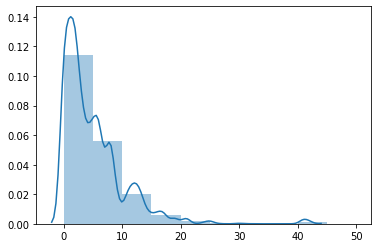

In [0]:
# get some basic stats about the number of keywords/queries for each service

q_lens = {}
serv_qs = {}
for nid in serv_nodes:
    node = serv_nodes[nid]
    
    sid = node['serv_id']
    serv_qs[sid] = []
    q_len = 0
    for code in node['codes']:
        code_node = hin_nodes[str(code_trans[code])]
        # print(code_node.keys())
        if 'keywords' not in code_node:
            continue
        # print(1)
        serv_qs[sid] = serv_qs[sid] + code_node['keywords']
        q_len += len(code_node['keywords'])
    q_lens[sid] = q_len
print("There are {} services with queries".format(sum([1 for q in q_lens if q_lens[q]])))
q_lens = list(q_lens.values())
print("Each service has an avg of {}, a median of {}, and variance of {}".format(
    np.mean(q_lens), np.median(q_lens), np.var(q_lens)
))
import seaborn as sns
sns.distplot(q_lens, bins=list(range(0,51,5)), label="Distribution of number of queries per service")

## Create Remaining Dataset Columns

In [0]:
ref_feats = refs_df[['ref_id', 'site_id', 'serv_id', 'timestamp',]]

serv_recs = {}
pbar = tqdm(list(serv_trans.keys()), mininterval=15, desc="Creating rec vectors...")
poss = []
negs = []

# for every service
for i, sid in enumerate(serv_trans):
    # recs = []
    recs = [0 for s in serv_trans]
    # for every service
    for j, s in enumerate(serv_trans):

        # if the "selected" (first: sid) service_id 
        if sid in ref_servs:
            # see if the "candidate" service (second: s)
            #  has been referred alongside the "selected" service
            s1 = set(ref_servs[sid])
            if s in s1:
                recs[j] = 1
        elif sid in rel_servs:
            # see if the "candidate" service (second: s)
            #  is related to "selected" service (via shared taxonomy codes)
            s2 = set(rel_servs[sid])
            if s in s2:
                recs[j] = 1
        elif sid in sim_servs:
            s3 = set(sim_servs[sid])
            # see if candidate service meets similarity threshold
            # to be related to selected servicee
            if s in s3:
                recs[j] = 1
        # else:
        #     recs.append(0)

    serv_recs[sid] = recs
    pos = sum(recs)
    neg = len(recs) - pos
    poss.append(pos)
    negs.append(neg)

    if i % 1000 == 0:
        avg_pos = sum(poss)/len(poss)
        avg_neg = sum(negs)/len(negs)
        print("avg positive recs: {} ---- negative recs: {}".format(avg_pos, avg_neg))
    pbar.update()








Creating rec vectors...:   0%|          | 0/16547 [00:00<?, ?it/s]

avg positive recs: 106.0 ---- negative recs: 16441.0









Creating rec vectors...:   1%|▏         | 216/16547 [00:15<18:54, 14.40it/s]





Linking referred and related services.: 100%|██████████| 100784/100784 [00:37<00:00, 1565.02it/s]






Creating rec vectors...:   2%|▏         | 385/16547 [00:25<18:42, 14.40it/s]






Creating rec vectors...:   3%|▎         | 445/16547 [00:30<18:19, 14.64it/s]






Creating rec vectors...:   4%|▍         | 629/16547 [00:45<18:07, 14.64it/s]






Creating rec vectors...:   4%|▍         | 630/16547 [00:46<19:54, 13.33it/s]






Creating rec vectors...:   5%|▍         | 797/16547 [01:01<20:52, 12.57it/s]






Creating rec vectors...:   6%|▌         | 997/16547 [01:15<20:36, 12.57it/s]

avg positive recs: 60.2007992007992 ---- negative recs: 16486.7992007992









Creating rec vectors...:   6%|▌         | 1011/16547 [01:16<19:52, 13.03it/s]






Creating rec vectors...:   7%|▋         | 1225/16547 [01:35<20:17, 12.59it/s]






Creating rec vectors...:   8%|▊         | 1321/16547 [01:45<20:09, 12.59it/s]






Creating rec vectors...:   8%|▊         | 1368/16547 [01:50<22:03, 11.47it/s]






Creating rec vectors...:  10%|▉         | 1587/16547 [02:05<20:23, 12.23it/s]






Creating rec vectors...:  10%|█         | 1716/16547 [02:15<20:12, 12.23it/s]






Creating rec vectors...:  11%|█         | 1796/16547 [02:20<19:25, 12.66it/s]






Creating rec vectors...:  12%|█▏        | 1990/16547 [02:35<19:09, 12.66it/s]






Creating rec vectors...:  12%|█▏        | 1991/16547 [02:35<19:06, 12.69it/s]

avg positive recs: 70.07546226886556 ---- negative recs: 16476.924537731134









Creating rec vectors...:  13%|█▎        | 2183/16547 [02:51<18:54, 12.66it/s]






Creating rec vectors...:  14%|█▍        | 2369/16547 [03:05<18:39, 12.66it/s]






Creating rec vectors...:  14%|█▍        | 2373/16547 [03:06<18:43, 12.62it/s]






Creating rec vectors...:  15%|█▌        | 2561/16547 [03:24<19:35, 11.89it/s]






Creating rec vectors...:  16%|█▋        | 2721/16547 [03:35<19:22, 11.89it/s]






Creating rec vectors...:  17%|█▋        | 2781/16547 [03:39<18:12, 12.60it/s]

avg positive recs: 73.04665111629457 ---- negative recs: 16473.953348883704









Creating rec vectors...:  18%|█▊        | 3027/16547 [03:54<16:39, 13.53it/s]






Creating rec vectors...:  19%|█▉        | 3180/16547 [04:05<16:28, 13.53it/s]






Creating rec vectors...:  20%|█▉        | 3231/16547 [04:09<16:23, 13.54it/s]






Creating rec vectors...:  21%|██        | 3407/16547 [04:25<16:10, 13.54it/s]






Creating rec vectors...:  21%|██        | 3408/16547 [04:25<17:27, 12.54it/s]






Creating rec vectors...:  22%|██▏       | 3569/16547 [04:41<18:33, 11.65it/s]






Creating rec vectors...:  23%|██▎       | 3755/16547 [04:55<18:17, 11.65it/s]






Creating rec vectors...:  23%|██▎       | 3767/16547 [04:57<17:40, 12.05it/s]






Creating rec vectors...:  24%|██▍       | 3969/16547 [05:12<16:53, 12.41it/s]

avg positive recs: 75.09972506873282 ---- negative recs: 16471.900274931268









Creating rec vectors...:  25%|██▍       | 4135/16547 [05:25<16:39, 12.41it/s]






Creating rec vectors...:  25%|██▌       | 4151/16547 [05:27<16:45, 12.33it/s]






Creating rec vectors...:  27%|██▋       | 4396/16547 [05:42<15:13, 13.30it/s]






Creating rec vectors...:  28%|██▊       | 4579/16547 [05:56<15:00, 13.30it/s]






Creating rec vectors...:  28%|██▊       | 4586/16547 [05:57<15:14, 13.08it/s]






Creating rec vectors...:  29%|██▉       | 4776/16547 [06:13<15:38, 12.54it/s]






Creating rec vectors...:  29%|██▉       | 4871/16547 [06:26<15:31, 12.54it/s]






Creating rec vectors...:  30%|██▉       | 4911/16547 [06:28<17:17, 11.21it/s]

avg positive recs: 73.8128374325135 ---- negative recs: 16473.187162567487









Creating rec vectors...:  31%|███       | 5095/16547 [06:43<16:35, 11.51it/s]






Creating rec vectors...:  31%|███▏      | 5185/16547 [06:56<16:27, 11.51it/s]






Creating rec vectors...:  32%|███▏      | 5233/16547 [06:58<17:37, 10.70it/s]






Creating rec vectors...:  33%|███▎      | 5456/16547 [07:13<15:49, 11.68it/s]






Creating rec vectors...:  34%|███▍      | 5596/16547 [07:26<15:37, 11.68it/s]






Creating rec vectors...:  34%|███▍      | 5651/16547 [07:29<15:04, 12.04it/s]






Creating rec vectors...:  35%|███▌      | 5846/16547 [07:44<14:37, 12.20it/s]

avg positive recs: 70.65105815697383 ---- negative recs: 16476.348941843025









Creating rec vectors...:  36%|███▋      | 6010/16547 [07:56<14:23, 12.20it/s]






Creating rec vectors...:  37%|███▋      | 6057/16547 [07:59<13:49, 12.65it/s]






Creating rec vectors...:  37%|███▋      | 6200/16547 [08:16<13:38, 12.65it/s]






Creating rec vectors...:  37%|███▋      | 6201/16547 [08:16<15:31, 11.11it/s]






Creating rec vectors...:  39%|███▊      | 6396/16547 [08:31<14:35, 11.59it/s]






Creating rec vectors...:  40%|███▉      | 6548/16547 [08:46<14:22, 11.59it/s]






Creating rec vectors...:  40%|███▉      | 6552/16547 [08:46<14:52, 11.20it/s]






Creating rec vectors...:  41%|████      | 6728/16547 [09:01<14:31, 11.26it/s]






Creating rec vectors...:  42%|████▏     | 6936/16547 [09:16<14:13, 11.26it/s]






Creating rec vectors...:  42%|████▏     | 6949/16547 [09:16<13:12, 12.12it/s]

avg positive recs: 70.70089987144694 ---- negative recs: 16476.29910012855









Creating rec vectors...:  43%|████▎     | 7170/16547 [09:35<12:57, 12.06it/s]






Creating rec vectors...:  44%|████▎     | 7217/16547 [09:46<12:53, 12.06it/s]






Creating rec vectors...:  44%|████▎     | 7218/16547 [09:51<24:11,  6.43it/s]






Creating rec vectors...:  45%|████▍     | 7423/16547 [10:06<19:54,  7.64it/s]






Creating rec vectors...:  45%|████▌     | 7492/16547 [10:16<19:45,  7.64it/s]






Creating rec vectors...:  46%|████▌     | 7547/16547 [10:21<19:14,  7.80it/s]






Creating rec vectors...:  47%|████▋     | 7703/16547 [10:36<17:29,  8.43it/s]






Creating rec vectors...:  47%|████▋     | 7780/16547 [10:46<17:20,  8.43it/s]






Creating rec vectors...:  48%|████▊     | 7862/16547 [10:51<16:07,  8.98it/s]

avg positive recs: 69.25546806649169 ---- negative recs: 16477.74453193351









Creating rec vectors...:  49%|████▊     | 8059/16547 [11:06<14:19,  9.88it/s]






Creating rec vectors...:  50%|████▉     | 8198/16547 [11:16<14:05,  9.88it/s]






Creating rec vectors...:  50%|█████     | 8286/16547 [11:22<12:29, 11.02it/s]






Creating rec vectors...:  51%|█████     | 8403/16547 [11:36<12:18, 11.02it/s]






Creating rec vectors...:  51%|█████     | 8404/16547 [11:38<14:25,  9.41it/s]






Creating rec vectors...:  52%|█████▏    | 8584/16547 [11:53<13:11, 10.06it/s]






Creating rec vectors...:  53%|█████▎    | 8760/16547 [12:06<12:54, 10.06it/s]






Creating rec vectors...:  53%|█████▎    | 8783/16547 [12:08<11:56, 10.84it/s]






Creating rec vectors...:  54%|█████▍    | 8982/16547 [12:23<11:03, 11.40it/s]

avg positive recs: 69.03855127208088 ---- negative recs: 16477.961448727918









Creating rec vectors...:  55%|█████▌    | 9129/16547 [12:36<10:50, 11.40it/s]






Creating rec vectors...:  55%|█████▌    | 9158/16547 [12:38<10:43, 11.49it/s]






Creating rec vectors...:  56%|█████▋    | 9344/16547 [12:53<10:14, 11.73it/s]






Creating rec vectors...:  57%|█████▋    | 9498/16547 [13:06<10:00, 11.73it/s]






Creating rec vectors...:  58%|█████▊    | 9517/16547 [13:09<10:04, 11.62it/s]






Creating rec vectors...:  59%|█████▊    | 9694/16547 [13:24<09:49, 11.63it/s]






Creating rec vectors...:  60%|█████▉    | 9849/16547 [13:36<09:35, 11.63it/s]






Creating rec vectors...:  60%|█████▉    | 9876/16547 [13:39<09:29, 11.72it/s]

avg positive recs: 72.05959404059594 ---- negative recs: 16474.940405959405









Creating rec vectors...:  61%|██████    | 10056/16547 [13:55<09:19, 11.61it/s]






Creating rec vectors...:  62%|██████▏   | 10191/16547 [14:06<09:07, 11.61it/s]






Creating rec vectors...:  62%|██████▏   | 10265/16547 [14:10<08:34, 12.21it/s]






Creating rec vectors...:  63%|██████▎   | 10474/16547 [14:25<07:59, 12.68it/s]






Creating rec vectors...:  64%|██████▍   | 10649/16547 [14:36<07:45, 12.68it/s]






Creating rec vectors...:  65%|██████▍   | 10715/16547 [14:40<07:12, 13.48it/s]






Creating rec vectors...:  66%|██████▌   | 10938/16547 [14:56<06:52, 13.59it/s]






Creating rec vectors...:  66%|██████▌   | 10938/16547 [14:56<06:52, 13.59it/s]

avg positive recs: 70.96191255340423 ---- negative recs: 16476.038087446595









Creating rec vectors...:  67%|██████▋   | 11056/16547 [15:07<06:44, 13.59it/s]






Creating rec vectors...:  67%|██████▋   | 11130/16547 [15:11<06:46, 13.32it/s]






Creating rec vectors...:  68%|██████▊   | 11319/16547 [15:27<06:32, 13.32it/s]






Creating rec vectors...:  68%|██████▊   | 11320/16547 [15:27<06:40, 13.07it/s]






Creating rec vectors...:  70%|██████▉   | 11545/16547 [15:42<06:08, 13.59it/s]






Creating rec vectors...:  71%|███████   | 11762/16547 [15:57<05:52, 13.59it/s]






Creating rec vectors...:  71%|███████   | 11763/16547 [15:57<05:45, 13.84it/s]






Creating rec vectors...:  72%|███████▏  | 11952/16547 [16:17<05:31, 13.84it/s]






Creating rec vectors...:  72%|███████▏  | 11953/16547 [16:17<06:17, 12.17it/s]

avg positive recs: 71.74293808849262 ---- negative recs: 16475.257061911507









Creating rec vectors...:  74%|███████▎  | 12174/16547 [16:32<05:40, 12.83it/s]






Creating rec vectors...:  75%|███████▍  | 12341/16547 [16:47<05:27, 12.83it/s]






Creating rec vectors...:  75%|███████▍  | 12344/16547 [16:47<05:40, 12.34it/s]






Creating rec vectors...:  76%|███████▋  | 12656/16547 [17:02<04:36, 14.05it/s]






Creating rec vectors...:  78%|███████▊  | 12915/16547 [17:17<04:18, 14.05it/s]






Creating rec vectors...:  78%|███████▊  | 12916/16547 [17:17<04:03, 14.88it/s]

avg positive recs: 70.0070763787401 ---- negative recs: 16476.99292362126









Creating rec vectors...:  80%|███████▉  | 13175/16547 [17:35<03:48, 14.77it/s]






Creating rec vectors...:  81%|████████  | 13368/16547 [17:47<03:35, 14.77it/s]






Creating rec vectors...:  81%|████████  | 13413/16547 [17:50<03:27, 15.07it/s]






Creating rec vectors...:  82%|████████▏ | 13649/16547 [18:07<03:12, 15.07it/s]






Creating rec vectors...:  82%|████████▏ | 13650/16547 [18:07<03:17, 14.69it/s]






Creating rec vectors...:  84%|████████▍ | 13859/16547 [18:24<03:15, 13.74it/s]

avg positive recs: 70.31019212913364 ---- negative recs: 16476.689807870865









Creating rec vectors...:  85%|████████▍ | 14049/16547 [18:37<03:01, 13.74it/s]






Creating rec vectors...:  85%|████████▌ | 14102/16547 [18:39<02:49, 14.38it/s]






Creating rec vectors...:  87%|████████▋ | 14332/16547 [18:57<02:38, 14.00it/s]






Creating rec vectors...:  87%|████████▋ | 14332/16547 [18:57<02:38, 14.00it/s]






Creating rec vectors...:  88%|████████▊ | 14505/16547 [19:07<02:25, 14.00it/s]






Creating rec vectors...:  88%|████████▊ | 14593/16547 [19:12<02:11, 14.87it/s]






Creating rec vectors...:  90%|████████▉ | 14814/16547 [19:27<01:56, 14.87it/s]






Creating rec vectors...:  90%|████████▉ | 14815/16547 [19:27<01:56, 14.84it/s]

avg positive recs: 69.8951403239784 ---- negative recs: 16477.104859676023









Creating rec vectors...:  91%|█████████ | 15037/16547 [19:45<01:47, 14.07it/s]






Creating rec vectors...:  92%|█████████▏| 15181/16547 [19:57<01:37, 14.07it/s]






Creating rec vectors...:  92%|█████████▏| 15208/16547 [20:00<01:41, 13.14it/s]






Creating rec vectors...:  93%|█████████▎| 15416/16547 [20:15<01:24, 13.35it/s]






Creating rec vectors...:  94%|█████████▍| 15572/16547 [20:27<01:13, 13.35it/s]






Creating rec vectors...:  94%|█████████▍| 15617/16547 [20:30<01:09, 13.35it/s]






Creating rec vectors...:  96%|█████████▋| 15938/16547 [20:45<00:40, 15.04it/s]

avg positive recs: 69.39635022811075 ---- negative recs: 16477.60364977189









Creating rec vectors...:  98%|█████████▊| 16180/16547 [20:57<00:24, 15.04it/s]






Creating rec vectors...:  98%|█████████▊| 16248/16547 [21:00<00:18, 16.37it/s]






Creating rec vectors...:  99%|█████████▉| 16350/16547 [21:17<00:12, 16.37it/s]






Creating rec vectors...:  99%|█████████▉| 16351/16547 [21:17<00:18, 10.73it/s]






Creating rec vectors...: 100%|█████████▉| 16477/16547 [21:32<00:07,  9.85it/s]

In [0]:
fname = os.path.join(prefix, 'data', 'service_recommendations.json')
with open(fname, 'w') as f:
    json.dump(serv_recs, f)








Creating rec vectors...: 100%|██████████| 16547/16547 [21:47<00:00,  9.85it/s]

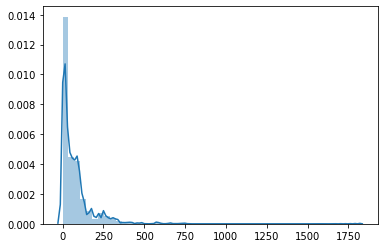

In [0]:
sns.distplot(poss, label="Distribution of number of positive recs per service")

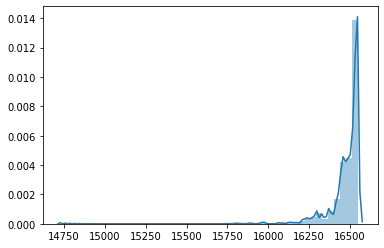

In [0]:
sns.distplot(negs, label="Distribution of number of negative recs per service")

In [0]:
# Load the TF-Hub module
print("Loading the TF-Hub {} module...".format(MODEL))
%time embed_fn = hub.load(MODEL_URL)
print("TF-Hub module is loaded.")

def extract_embed(queries):
    # Generates the embedding for the query
    query_embedding =  embed_fn(queries).numpy()
    # print(len(query_embedding))
    return query_embedding

Loading the TF-Hub USE module...
CPU times: user 7.89 s, sys: 3.22 s, total: 11.1 s
Wall time: 17.1 s
TF-Hub module is loaded.


In [0]:
# save query embeddings to speed up calculations below
tagged_q_embeds = {}
pbar = tqdm(queries, mininterval=5, desc='Embedding queries')
for query in queries:
    tagged_q_embeds[query] = extract_embed([query])
    pbar.update(1)









Embedding queries:   0%|          | 0/43950 [00:00<?, ?it/s]







Embedding queries:   5%|▍         | 1999/43950 [00:05<01:44, 399.73it/s]







Embedding queries:   9%|▉         | 4118/43950 [00:10<01:37, 406.66it/s]







Embedding queries:  14%|█▍        | 6174/43950 [00:15<01:32, 407.97it/s]







Embedding queries:  19%|█▉        | 8320/43950 [00:20<01:26, 414.10it/s]







Embedding queries:  23%|██▎       | 10313/43950 [00:25<01:22, 409.27it/s]







Embedding queries:  29%|██▊       | 12581/43950 [00:30<01:14, 421.59it/s]







Embedding queries:  34%|███▎      | 14777/43950 [00:35<01:08, 426.71it/s]







Embedding queries:  38%|███▊      | 16751/43950 [00:40<01:05, 412.13it/s]







Embedding queries:  43%|████▎     | 18706/43950 [00:45<01:03, 399.38it/s]







Embedding queries:  47%|████▋     | 20633/43950 [00:50<00:59, 392.85it/s]







Embedding queries:  52%|█████▏    | 22735/43950 [00:55<00:52, 400.69it/s]







Embedding queries:  56%|█████▋    | 2

In [0]:
list(tagged_texts.values())[0]

['school district',
 'administers elementary middle high school school district',
 'provides student transportation service maintains information school location enrollment fee curriculum',
 'district provides information regarding special education service student age disability student transportation service',
 'program usually within formal education system operate school bus transport student school',
 'also included program issue voucher enable student use mean transportation school reimburse parent situation child served school transportation system school bus',
 'school bus service',
 'school district issued student bus pass',
 'school transportation program',
 'student transportation reimbursement',
 'student transportation voucher',
 'living within school district grade k']

In [0]:
n_samples = 0

filename = os.path.join(prefix, 'data', 'wide_deep_dataset_chkpnt.csv')
# keep text and convert/fetch during training to avoid absurd file size
feat_names = [
            'Distance',
            'Embedding_Similarity',
            'UNIX_Timestamp',
            'Selected_Text_Content',
            'Candidate_Text_Content', 
            'Previously_Recommended',
            'Query',
            'Label'
]
    
uniq_refs = list(set(list(serv_refs['serv_id'])))
in_sids = set(serv_ids)
uniq_refs = [ref for ref in uniq_refs if ref in in_sids]
sid_idxs = {}
for i, sid in enumerate(serv_ids):
    sid_idxs[sid] = i
nid_idxs = {}
for i, nid in enumerate(tagged_texts.keys()):
    nid_idxs[nid] = i

site_trans = {}
for nid, node in hin_nodes.items():
    if 'SITE_ID' in node:
        sid = str(node['SITE_ID'])
        site_trans[sid] = str(node['node_num'])
rows = [feat_names]


def create_dataset(data):

    # get the start and end index for this data chunk
    start = data[0][0]
    end = data[-1][0]
    prefix = './drive/My Drive/ND_CSE/Year_1/Research:Care-Net/JBDF_CareNet/Care-Net Backend/code_and_data'
    data_path = os.path.join(prefix, 'data', 'wide_deep_dataset_chunks')
    filename = os.path.join(data_path, "wide_deep_dataset_chkpnt_{}-{}.csv".format(start,end))
    n_errs = 0

    if os.path.exists(filename):
        print("Skipping data chunk ({}, {}). Already Processed...".format(start,end))
        return n_errs

    rows = [[
            'Distance',
            'Embedding_Similarity',
            'Month',
            'Selected_Service_ID'
            'Selected_Text_Content',
            'Candidate_Text_Content', 
            'Previously_Recommended',
            'Query',
            'Label'
    ]]
    pbar = tqdm(data, mininterval=300, desc="Creating dataset...")
    for ref_idx, site_id, ref_sid, ts in data:

        # global pbar, n_samples
        if ref_sid in serv_recs:

            refs = serv_recs[ref_sid]

            pos_recs = []
            neg_recs = []
            for i, ref in enumerate(refs):
                
                if ref:
                    pos_recs.append(list(serv_trans.keys())[i])
                else:
                    neg_recs.append(list(serv_trans.keys())[i])
            k = 4
            k_neg_samples = k * len(pos_recs)
            neg_samples = random.sample(neg_recs, k_neg_samples)


            
            # get some samples of some keywords/queries
            kw_sample = 1
            if ref_sid in serv_trans:
                
                sid = serv_trans[ref_sid]
                codes = serv_nodes[sid]
                if 'codes' in codes:
                    codes = codes['codes']
                    keywords = []
                    for code in codes:
                        code_node = hin_nodes[str(code_trans[code])]
                        if 'keywords' in code_node:
                            kws = code_node['keywords']
                            keywords.append(kws)
                            keywords = [kw for kws in keywords for kw in kws]
            else:
                keywords = None
                        
                    
                
            # user_serv_idx = sid_idxs[]
            recs = [(rec, 1) for rec in pos_recs] + [(rec, 0) for rec in neg_samples]
            recs = [(rec, lbl) for rec, lbl in recs if rec in serv_trans]
            desc = "Adding recommendation examples for ref {}/{}".format(ref_idx+1, len(site_ids))
            pbar2 = tqdm(recs, mininterval=150, desc=desc)
            pos_recs = [x[0] for x in pos_recs]
            for rec, label in recs:
                rec = str(rec)
                row = []
                
                try:
                    nid = serv_trans[rec]
                except Exception as e:
                    print("Missing sid", type(rec), e)
                    # pbar2.update(1)
                    n_errs += 1
                    continue
                candidate_node = serv_nodes[nid]
                candidate_sites = []
                tmp = candidate_node['SERV_SITES']
                tmp = tmp.replace('nan', '\'\'')
                try:
                    tmp = ast.literal_eval(tmp)
                except Exception as e:
                    print(e)
                    n_errs += 1
                    pbar2.update(1)
                    continue
                for site in tmp:
                    candidate_sites.append(str(site['Site_Id']))
                try:
                    site_nodes = [hin_nodes[site_trans[sid]] for sid in candidate_sites]
                except Exception as e:
                    print("Missing sid", type(sid), e)
                    n_errs += 1
                    pbar2.update(1)
                    continue
                if len(site_nodes) == 0:
                    print(site_nodes)
                try:
                    tmp = site_nodes[0]['SITE_ADDR']
                except Exception as e:
                    print(e)
                    n_errs += 1
                    pbar2.update(1)
                    continue
                nan = None
                zips = []#[eval(node['SITE_ADDR'])['zip'] for node in site_nodes]
                for i in range(len(site_nodes)):
                    tmp = site_nodes[i]['SITE_ADDR']
                    tmp = tmp.replace('nan', '\'\'')
                    try:
                        tmp = ast.literal_eval(tmp)['zip']
                    except Exception as e:
                        print(e)
                        n_errs += 1
                        continue
                    zips.append(tmp)
                try:
                    sel_node = hin_nodes[site_trans[site_id]]
                except:
                    continue
                sel_zip = []
                # for site_node in sel_node:
                tmp = sel_node['SITE_ADDR']
                tmp = tmp.replace('nan', '\'\'')
                try:
                    tmp = ast.literal_eval(tmp)['zip']
                except Exception as e:
                    print(e)
                    n_errs += 1
                    continue
                sel_zips = [tmp] * len(zips)

                # pick the smallest distance to a service's available sites
                geodist = pgeocode.GeoDistance(country='us')
                zip_dists = geodist.query_postal_code(zips, sel_zips)
                min_dist = min(zip_dists)
                # min_dist_idx = zip_dists.indexOf(min(zip_dists))
                
                mts = ts.split(' ')
                # # split up date components
                mts[0] = mts[0].split('-')
                mts[1] = mts[1].split(':')
                mts = mts[0] + mts[1]
                yr, mon, day, hr, mins, secs = mts
                # unix_ts = datetime.datetime(year=int(yr), month=int(mon), day=int(day), hour=int(hr), minute=int(mins), second=int(secs))
                mts = mon
                # unix_ts = int(unix_ts.timestamp())

                # get service embedings
                c_idx = sid_idxs[rec]
                s_idx = sid_idxs[ref_sid]

                candidate_nid = int(serv_trans[rec])
                selected_nid = int(serv_trans[ref_sid])
                embed_sim = sim_mtx[s_idx][c_idx]

                row = [
                    # ref_idx,
                    min_dist,
                    embed_sim,
                    mts,
                    selected_nid,
                    candidate_nid, 
                    pos_recs
                ]
                # print(row)
                if keywords:
                    # kw_embs = extract_embed(keywords)
                    # for kw_emb in kw_embs:
                    for kw in keywords:
                        tmp_row = row + [kw, label]
                        rows.append(tmp_row)
                        
                else:
                    # kw_emb = extract_embed([''])
                    kw = ''
                    tmp_row = row + [kw, label]
                    rows.append(tmp_row)

                pbar2.update(1)
        
        else:
            n_errs += 1

        # print(len(data_df))
        # data_df.to_csv(filename)
    with open(filename, 'w+') as cf:
        # for row in rows:
        #     nonblock.bgwrite(cf,row)
        writer = csv.writer(cf, delimiter=',')
        writer.writerows(rows)
    print("Successfully saved processed dataset chunk ({}, {})".format(start,end))
    rows = []
    print("Processed {}/{} samples successfully".format((len(data) - n_errs), len(data)))
    pbar.update(1)

    

    return n_errs

In [0]:
# get these feats as a list of lists
ref_feats = list(map(lambda x: list(x), list(refs_df[['site_id', 'serv_id', 'timestamp',]].values)))
site_ids = [feat[0] for feat in ref_feats]
ref_sids = [feat[1] for feat in ref_feats]
timestamps = [feat[2] for feat in ref_feats]
idxs = list(range(len(site_ids)))
data = zip(idxs, site_ids, ref_sids, timestamps)
data = [(i, site_id, ref_sid, ts) for i, site_id, ref_sid, ts in data if ref_sid in serv_recs]

print()

In [0]:
def split(a, n):
    n = min(n, len(a))
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

data_chunks = list(split(data, 3400))
data_path = os.path.join(prefix, 'data', 'wide_deep_dataset_chunks')
os.makedirs(data_path, exist_ok=True)

In [0]:
pool = multiprocessing.Pool(processes=4)

with tqdm(total=len(data_chunks), desc="Processing Dataset") as pbar:
    for i, _ in enumerate(pool.imap_unordered(create_dataset, data_chunks)):
        pbar.update(1)











Processing Dataset:   0%|          | 0/3400 [00:00<?, ?it/s]

Skipping data chunk (64, 127). Already Processed...
Skipping data chunk (192, 300). Already Processed...
Skipping data chunk (0, 63). Already Processed...
Skipping data chunk (128, 191). Already Processed...
Skipping data chunk (301, 364). Already Processed...
Skipping data chunk (429, 492). Already Processed...
Skipping data chunk (557, 620). Already Processed...
Skipping data chunk (493, 556). Already Processed...
Skipping data chunk (365, 428). Already Processed...
Skipping data chunk (685, 748). Already Processed...
Skipping data chunk (621, 684). Already Processed...
Skipping data chunk (749, 911). Already Processed...
Skipping data chunk (976, 1039). Already Processed...
Skipping data chunk (912, 975). Already Processed...
Skipping data chunk (1104, 1167). Already Processed...
Skipping data chunk (1040, 1103). Already Processed...
Skipping data chunk (1168, 1231). Already Processed...
Skipping data chunk (1232, 1295). Already Processed...
Skipping data chunk (1360, 1423). Already










Processing Dataset:   1%|          | 20/3400 [00:00<00:17, 194.23it/s]

Skipping data chunk (1572, 1771). Already Processed...
Skipping data chunk (1900, 1965). Already Processed...
Skipping data chunk (1772, 1835). Already Processed...
Skipping data chunk (1836, 1899). Already Processed...
Skipping data chunk (1966, 2029). Already Processed...
Skipping data chunk (2030, 2093). Already Processed...
Skipping data chunk (2094, 2157). Already Processed...
Skipping data chunk (2222, 2285). Already Processed...
Skipping data chunk (2158, 2221). Already Processed...
Skipping data chunk (2286, 2349). Already Processed...
Skipping data chunk (2350, 2413). Already Processed...
Skipping data chunk (2478, 2541). Already Processed...
Skipping data chunk (2414, 2477). Already Processed...
Skipping data chunk (2681, 2744). Already Processed...
Skipping data chunk (2606, 2680). Already Processed...
Skipping data chunk (2542, 2605). Already Processed...
Skipping data chunk (2745, 2808). Already Processed...
Skipping data chunk (2939, 3002). Already Processed...
Skipping d










Processing Dataset:   2%|▏         | 58/3400 [00:00<00:14, 226.54it/s]

Skipping data chunk (4063, 4126). Already Processed...


Skipping data chunk (4256, 4319). Already Processed...
Skipping data chunk (4448, 4511). Already Processed...
Skipping data chunk (4320, 4383). Already Processed...
Skipping data chunk (4384, 4447). Already Processed...
Skipping data chunk (4576, 4640). Already Processed...
Skipping data chunk (4641, 4704). Already Processed...
Skipping data chunk (4512, 4575). Already Processed...
Skipping data chunk (4769, 4832). Already Processed...
Skipping data chunk (4961, 5024). Already Processed...
Skipping data chunk (5025, 5088). Already Processed...
Skipping data chunk (5089, 5152). Already Processed...
Skipping data chunk (4833, 4896). Already Processed...
Skipping data chunk (4897, 4960). Already Processed...
Skipping data chunk (4705, 4768). Already Processed...
Skipping data chunk (5281, 5344). Already Processed...
Skipping data chunk (5153, 5216). Already Processed...
Skipping data chunk (5409, 5472). Already Processed...
Skipping data chunk (5217, 5280). Already Processed...
Skipping d










Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]








Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]








Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]








Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]









Adding recommendation examples for ref 5749/266155:   0%|          | 0/270 [00:00<?, ?it/s]







Embedding queries: 100%|██████████| 43950/43950 [02:01<00:00, 408.68it/s]









Adding recommendation examples for ref 5538/266155:   0%|          | 0/1655 [00:00<?, ?it/s]









Adding recommendation examples for ref 5670/266155:   0%|          | 0/235 [00:00<?, ?it/s]









Adding recommendation examples for ref 5602/266155:   0%|          | 0/580 [00:00<?, ?it/s]

Missing sid <class 'str'> '15899'











Processing Dataset:   2%|▏         | 81/3400 [00:18<00:14, 226.54it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5963'












Adding recommendation examples for ref 5749/266155:  89%|████████▉ | 241/270 [02:30<00:18,  1.60it/s]









Adding recommendation examples for ref 5538/266155:  15%|█▍        | 241/1655 [02:30<14:42,  1.60it/s]









Adding recommendation examples for ref 5602/266155:  42%|████▏     | 243/580 [02:30<03:28,  1.62it/s]

Missing sid <class 'str'> '9912'













Adding recommendation examples for ref 5671/266155:   0%|          | 0/45 [00:00<?, ?it/s]










Adding recommendation examples for ref 5670/266155: 100%|██████████| 235/235 [02:35<00:00,  1.51it/s]











Adding recommendation examples for ref 5750/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5749/266155: 100%|██████████| 270/270 [02:57<00:00,  1.52it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5672/266155:   0%|          | 0/45 [00:00<?, ?it/s]










Adding recommendation examples for ref 5671/266155: 100%|██████████| 45/45 [00:37<00:00,  1.19it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9157'













Adding recommendation examples for ref 5673/266155:   0%|          | 0/45 [00:00<?, ?it/s]










Adding recommendation examples for ref 5672/266155: 100%|██████████| 45/45 [00:35<00:00,  1.25it/s]











Adding recommendation examples for ref 5674/266155:   0%|          | 0/45 [00:00<?, ?it/s]










Adding recommendation examples for ref 5673/266155: 100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 5538/266155:  29%|██▉       | 482/1655 [05:00<12:12,  1.60it/s]










Adding recommendation examples for ref 5675/266155:   0%|          | 0/45 [00:00<?, ?it/s]










Adding recommendation examples for ref 5674/266155: 100%|██████████| 45/45 [00:37<00:00,  1.21it/s]










Adding recommendation examples for ref 5602/266155:  84%|████████▍ | 486/580 [05:05<00:58,  1.60it/s]

Missing sid <class 'str'> '6922'












Adding recommendation examples for ref 5750/266155:  89%|████████▊ | 239/270 [02:30<00:19,  1.59it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5676/266155:   0%|          | 0/45 [00:00<?, ?it/s]










Adding recommendation examples for ref 5675/266155: 100%|██████████| 45/45 [00:35<00:00,  1.26it/s]











Adding recommendation examples for ref 5751/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5750/266155: 100%|██████████| 270/270 [02:58<00:00,  1.51it/s]


Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 5603/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5602/266155: 100%|██████████| 580/580 [06:12<00:00,  1.56it/s]











Adding recommendation examples for ref 5677/266155:   0%|          | 0/45 [00:00<?, ?it/s]










Adding recommendation examples for ref 5676/266155: 100%|██████████| 45/45 [00:36<00:00,  1.23it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5678/266155:   0%|          | 0/45 [00:00<?, ?it/s]










Adding recommendation examples for ref 5677/266155: 100%|██████████| 45/45 [00:36<00:00,  1.23it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5679/266155:   0%|          | 0/45 [00:00<?, ?it/s]










Adding recommendation examples for ref 5678/266155: 100%|██████████| 45/45 [00:36<00:00,  1.22it/s]










Adding recommendation examples for ref 5538/266155:  44%|████▎     | 723/1655 [07:31<09:42,  1.60it/s]










Adding recommendation examples for ref 5680/266155:   0%|          | 0/45 [00:00<?, ?it/s]










Adding recommendation examples for ref 5679/266155: 100%|██████████| 45/45 [00:37<00:00,  1.21it/s]










Adding recommendation examples for ref 5751/266155:  89%|████████▉ | 240/270 [02:30<00:18,  1.60it/s]










Adding recommendation examples for ref 5681/266155:   0%|          | 0/45 [00:00<?, ?it/s]










Adding recommendation examples for ref 5680/266155: 100%|██████████| 45/45 [00:36<00:00,  1.24it/s]










Adding recommendation examples for ref 5603/266155:  41%|████      | 239/580 [02:30<03:34,  1.59it/s]










Adding recommendati

Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 5682/266155:   0%|          | 0/45 [00:00<?, ?it/s]










Adding recommendation examples for ref 5681/266155: 100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '1923'













Adding recommendation examples for ref 5683/266155:   0%|          | 0/570 [00:00<?, ?it/s]










Adding recommendation examples for ref 5682/266155: 100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 5538/266155:  58%|█████▊    | 963/1655 [10:03<07:13,  1.60it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5603/266155:  82%|████████▏ | 478/580 [05:03<01:04,  1.58it/s]

Missing sid <class 'str'> '1923'












Adding recommendation examples for ref 5752/266155:  88%|████████▊ | 237/270 [02:30<00:20,  1.58it/s]

Missing sid <class 'str'> '3275'













Adding recommendation examples for ref 5753/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5752/266155: 100%|██████████| 270/270 [02:59<00:00,  1.51it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5683/266155:  42%|████▏     | 237/570 [02:30<03:31,  1.58it/s]










Adding recommendation examples for ref 5604/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5603/266155: 100%|██████████| 580/580 [06:17<00:00,  1.54it/s]










Adding recommendation examples for ref 5538/266155:  73%|███████▎  | 1201/1655 [12:35<04:46,  1.59it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 5753/266155:  88%|████████▊ | 238/270 [02:30<00:20,  1.59it/s]

Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5754/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5753/266155: 100%|██████████| 270/270 [02:58<00:00,  1.52it/s]










Adding recommendation examples for ref 5683/266155:  83%|████████▎ | 474/570 [05:01<01:00,  1.57it/s]

Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 5604/266155:  41%|████      | 239/580 [02:30<03:34,  1.59it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5538/266155:  87%|████████▋ | 1438/1655 [15:06<02:17,  1.58it/s]

Missing sid <class 'str'> '13673'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1399'













Adding recommendation examples for ref 5684/266155:   0%|          | 0/50 [00:00<?, ?it/s]










Adding recommendation examples for ref 5683/266155: 100%|██████████| 570/570 [06:09<00:00,  1.54it/s]


unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5685/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5684/266155: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '5885'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5754/266155:  88%|████████▊ | 237/270 [02:30<00:20,  1.58it/s]










Adding recommendation examples for ref 5539/266155:   0%|          | 0/1655 [00:00<?, ?it/s]










Adding recommendation examples for ref 5538/266155: 100%|██████████| 1655/1655 [17:32<00:00,  1.57it/s]










Adding recommendation examples for ref 5604/266155:  82%|████████▏ | 478/580 [05:03<01:04,  1.58it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5755/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5754/266155: 100%|██████████| 270/270 [02:58<00:00,  1.51it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5605/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5604/266155: 100%|██████████| 580/580 [06:17<00:00,  1.54it/s]











Adding recommendation examples for ref 5686/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5685/266155: 100%|██████████| 185/185 [02:04<00:00,  1.48it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '5963'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '13673'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5539/266155:  14%|█▍        | 236/1655 [02:30<15:05,  1.57it/s]

Missing sid <class 'str'> '9912'












Adding recommendation examples for ref 5755/266155:  87%|████████▋ | 236/270 [02:30<00:21,  1.57it/s]










Adding recommendation examples for ref 5756/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5755/266155: 100%|██████████| 270/270 [03:00<00:00,  1.49it/s]











Adding recommendation examples for ref 5687/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5686/266155: 100%|██████████| 185/185 [02:05<00:00,  1.48it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5605/266155:  41%|████      | 236/580 [02:30<03:39,  1.57it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5539/266155:  29%|██▊       | 475/1655 [05:00<12:29,  1.57it/s]










Adding recommendation examples for ref 5688/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5687/266155: 100%|██████████| 185/185 [02:04<00:00,  1.49it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'












Adding recommendation examples for ref 5756/266155:  86%|████████▋ | 233/270 [02:30<00:23,  1.55it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9157'












Adding recommendation examples for ref 5605/266155:  81%|████████▏ | 472/580 [05:01<01:08,  1.57it/s]










Adding recommendation examples for ref 5757/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5756/266155: 100%|██████████| 270/270 [03:03<00:00,  1.47it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5689/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5688/266155: 100%|██████████| 185/185 [02:03<00:00,  1.50it/s]










Adding recommendation examples for ref 5539/266155:  43%|████▎     | 714/1655 [07:32<09:57,  1.57it/s]










Adding recommendation examples for ref 5606/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5605/266155: 100%|██████████| 580/580 [06:19<00:00,  1.53it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
[]
list index out of range
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5757/266155:  88%|████████▊ | 237/270 [02:30<00:20,  1.58it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5758/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5757/266155: 100%|██████████| 270/270 [02:59<00:00,  1.50it/s]


Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 5690/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5689/266155: 100%|██████████| 185/185 [02:05<00:00,  1.48it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5539/266155:  57%|█████▋    | 950/1655 [10:04<07:29,  1.57it/s]









Adding recommendation examples for ref 5606/266155:  41%|████      | 238/580 [02:30<03:36,  1.58it/s]

Missing sid <class 'str'> '12958'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5691/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5690/266155: 100%|██████████| 185/185 [02:04<00:00,  1.48it/s]


Missing sid <class 'str'> '1399'












Adding recommendation examples for ref 5758/266155:  87%|████████▋ | 235/270 [02:30<00:22,  1.56it/s]

Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5759/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5758/266155: 100%|██████████| 270/270 [03:01<00:00,  1.49it/s]


Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 5539/266155:  72%|███████▏  | 1188/1655 [12:35<04:56,  1.57it/s]









Adding recommendation examples for ref 5606/266155:  82%|████████▏ | 476/580 [05:01<01:05,  1.58it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5692/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5691/266155: 100%|██████████| 185/185 [02:07<00:00,  1.46it/s]











Adding recommendation examples for ref 5607/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5606/266155: 100%|██████████| 580/580 [06:16<00:00,  1.54it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5759/266155:  86%|████████▌ | 232/270 [02:30<00:24,  1.55it/s]

Missing sid <class 'str'> '12958'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5539/266155:  86%|████████▌ | 1426/1655 [15:06<02:25,  1.57it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5760/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5759/266155: 100%|██████████| 270/270 [03:02<00:00,  1.48it/s]


Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 5693/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5692/266155: 100%|██████████| 185/185 [02:04<00:00,  1.49it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5607/266155:  41%|████      | 236/580 [02:30<03:38,  1.57it/s]










Adding recommendation examples for ref 5540/266155:   0%|          | 0/1655 [00:00<?, ?it/s]










Adding recommendation examples for ref 5539/266155: 100%|██████████| 1655/1655 [17:39<00:00,  1.56it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5760/266155:  86%|████████▌ | 231/270 [02:30<00:25,  1.54it/s]










Adding recommendation examples for ref 5694/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5693/266155: 100%|██████████| 185/185 [02:06<00:00,  1.47it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5761/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5760/266155: 100%|██████████| 270/270 [03:03<00:00,  1.47it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 5607/266155:  81%|████████▏ | 472/580 [05:04<01:09,  1.56it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5963'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5695/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5694/266155: 100%|██████████| 185/185 [02:04<00:00,  1.49it/s]










Adding recommendation examples for ref 5540/266155:  14%|█▍        | 235/1655 [02:30<15:09,  1.56it/s]

Missing sid <class 'str'> '5885'













Adding recommendation examples for ref 5608/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5607/266155: 100%|██████████| 580/580 [06:22<00:00,  1.52it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9157'












Adding recommendation examples for ref 5761/266155:  87%|████████▋ | 235/270 [02:30<00:22,  1.56it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5762/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5761/266155: 100%|██████████| 270/270 [03:02<00:00,  1.48it/s]


Missing sid <class 'str'> '1923'
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5696/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5695/266155: 100%|██████████| 185/185 [02:04<00:00,  1.48it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5540/266155:  28%|██▊       | 470/1655 [05:01<12:40,  1.56it/s]









Adding recommendation examples for ref 5608/266155:  40%|████      | 234/580 [02:30<03:42,  1.56it/s]

Missing sid <class 'str'> '9154'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '10301'












Adding recommendation examples for ref 5762/266155:  87%|████████▋ | 234/270 [02:30<00:23,  1.56it/s]










Adding recommendation examples for ref 5697/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5696/266155: 100%|██████████| 185/185 [02:06<00:00,  1.47it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'













Adding recommendation examples for ref 5763/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5762/266155: 100%|██████████| 270/270 [03:01<00:00,  1.49it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5540/266155:  43%|████▎     | 705/1655 [07:32<10:08,  1.56it/s]









Adding recommendation examples for ref 5608/266155:  81%|████████  | 468/580 [05:01<01:11,  1.56it/s]

Missing sid <class 'str'> '4845'













Adding recommendation examples for ref 5698/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5697/266155: 100%|██████████| 185/185 [02:07<00:00,  1.45it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '5885'













Adding recommendation examples for ref 5609/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5608/266155: 100%|██████████| 580/580 [06:22<00:00,  1.52it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5763/266155:  86%|████████▌ | 231/270 [02:30<00:25,  1.54it/s]










Adding recommendation examples for ref 5764/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5763/266155: 100%|██████████| 270/270 [03:05<00:00,  1.45it/s]










Adding recommendation examples for ref 5540/266155:  57%|█████▋    | 941/1655 [10:02<07:37,  1.56it/s]

Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5699/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5698/266155: 100%|██████████| 185/185 [02:06<00:00,  1.47it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5609/266155:  40%|████      | 233/580 [02:30<03:44,  1.55it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5764/266155:  86%|████████▌ | 232/270 [02:30<00:24,  1.54it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5540/266155:  71%|███████   | 1179/1655 [12:33<05:03,  1.57it/s]

Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 5700/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5699/266155: 100%|██████████| 185/185 [02:05<00:00,  1.47it/s]











Adding recommendation examples for ref 5765/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5764/266155: 100%|██████████| 270/270 [03:02<00:00,  1.48it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5609/266155:  80%|████████  | 466/580 [05:01<01:13,  1.55it/s]










Adding recommendation examples for ref 5701/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5700/266155: 100%|██████████| 185/185 [02:07<00:00,  1.45it/s]










Adding recommendation examples for ref 5540/266155:  86%|████████▌ | 1417/1655 [15:08<02:32,  1.56it/s]

Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'













Adding recommendation examples for ref 5610/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5609/266155: 100%|██████████| 580/580 [06:23<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5765/266155:  86%|████████▌ | 232/270 [02:30<00:24,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5766/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5765/266155: 100%|██████████| 270/270 [03:03<00:00,  1.48it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5702/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5701/266155: 100%|██████████| 185/185 [02:03<00:00,  1.50it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5540/266155: 100%|█████████▉| 1647/1655 [17:39<00:05,  1.55it/s]









Adding recommendation examples for ref 5610/266155:  39%|███▉      | 227/580 [02:30<03:53,  1.51it/s]










Adding recommendation examples for ref 5541/266155:   0%|          | 0/1655 [00:00<?, ?it/s]










Adding recommendation examples for ref 5540/266155: 100%|██████████| 1655/1655 [17:52<00:00,  1.54it/s]










Adding recommendation examples for ref 5766/266155:  84%|████████▍ | 228/270 [02:30<00:27,  1.51it/s]

Missing sid <class 'str'> '373'
Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 5767/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5766/266155: 100%|██████████| 270/270 [03:07<00:00,  1.44it/s]











Adding recommendation examples for ref 5703/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5702/266155: 100%|██████████| 185/185 [02:08<00:00,  1.44it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '5963'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5610/266155:  79%|███████▉  | 458/580 [05:00<01:20,  1.52it/s]









Adding recommendation examples for ref 5541/266155:  14%|█▍        | 231/1655 [02:30<15:27,  1.54it/s]

Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5704/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5703/266155: 100%|██████████| 185/185 [02:08<00:00,  1.44it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'












Adding recommendation examples for ref 5767/266155:  85%|████████▍ | 229/270 [02:30<00:26,  1.52it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5611/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5610/266155: 100%|██████████| 580/580 [06:26<00:00,  1.50it/s]


Missing sid <class 'str'> '14062'













Adding recommendation examples for ref 5768/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5767/266155: 100%|██████████| 270/270 [03:06<00:00,  1.45it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5541/266155:  28%|██▊       | 467/1655 [05:00<12:48,  1.55it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '16582'
Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 5705/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5704/266155: 100%|██████████| 185/185 [02:06<00:00,  1.46it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5611/266155:  40%|████      | 234/580 [02:30<03:42,  1.55it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5768/266155:  85%|████████▍ | 229/270 [02:30<00:26,  1.52it/s]

Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5769/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5768/266155: 100%|██████████| 270/270 [03:03<00:00,  1.47it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5541/266155:  42%|████▏     | 703/1655 [07:33<10:16,  1.55it/s]

Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 5706/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5705/266155: 100%|██████████| 185/185 [02:04<00:00,  1.49it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '7902'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5611/266155:  81%|████████  | 468/580 [05:02<01:12,  1.55it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9992'













Adding recommendation examples for ref 5707/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5706/266155: 100%|██████████| 185/185 [02:14<00:00,  1.38it/s]










Adding recommendation examples for ref 5769/266155:  86%|████████▌ | 232/270 [02:30<00:24,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '5885'












Adding recommendation examples for ref 5541/266155:  56%|█████▋    | 935/1655 [10:05<07:47,  1.54it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5612/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5611/266155: 100%|██████████| 580/580 [06:24<00:00,  1.51it/s]


unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5770/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5769/266155: 100%|██████████| 270/270 [03:04<00:00,  1.46it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '4845'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '16582'













Adding recommendation examples for ref 5708/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5707/266155: 100%|██████████| 185/185 [02:09<00:00,  1.43it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5541/266155:  70%|███████   | 1165/1655 [12:37<05:19,  1.53it/s]

Missing sid <class 'str'> '16582'












Adding recommendation examples for ref 5612/266155:  40%|███▉      | 230/580 [02:30<03:48,  1.53it/s]









Adding recommendation examples for ref 5770/266155:  85%|████████▌ | 230/270 [02:30<00:26,  1.53it/s]

Missing sid <class 'str'> '5392'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5771/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5770/266155: 100%|██████████| 270/270 [03:04<00:00,  1.46it/s]


Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 5709/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5708/266155: 100%|██████████| 185/185 [02:08<00:00,  1.44it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5541/266155:  84%|████████▍ | 1394/1655 [15:07<02:50,  1.53it/s]









Adding recommendation examples for ref 5612/266155:  79%|███████▉  | 460/580 [05:03<01:18,  1.52it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5771/266155:  84%|████████▍ | 227/270 [02:30<00:28,  1.51it/s]










Adding recommendation examples for ref 5710/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5709/266155: 100%|██████████| 185/185 [02:08<00:00,  1.44it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5772/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5771/266155: 100%|██████████| 270/270 [03:07<00:00,  1.44it/s]











Adding recommendation examples for ref 5613/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5612/266155: 100%|██████████| 580/580 [06:32<00:00,  1.48it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5541/266155:  98%|█████████▊| 1623/1655 [17:41<00:21,  1.52it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5542/266155:   0%|          | 0/1655 [00:00<?, ?it/s]










Adding recommendation examples for ref 5541/266155: 100%|██████████| 1655/1655 [18:10<00:00,  1.52it/s]


Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 5711/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5710/266155: 100%|██████████| 185/185 [02:07<00:00,  1.45it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5772/266155:  83%|████████▎ | 225/270 [02:30<00:30,  1.50it/s]









Adding recommendation examples for ref 5613/266155:  40%|███▉      | 230/580 [02:30<03:48,  1.53it/s]

Missing sid <class 'str'> '373'
Missing sid <class 'str'> '5963'













Adding recommendation examples for ref 5773/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5772/266155: 100%|██████████| 270/270 [03:07<00:00,  1.44it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5712/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5711/266155: 100%|██████████| 185/185 [02:08<00:00,  1.44it/s]










Adding recommendation examples for ref 5542/266155:  14%|█▎        | 226/1655 [02:30<15:48,  1.51it/s]

Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5613/266155:  79%|███████▉  | 461/580 [05:00<01:17,  1.53it/s]









Adding recommendation examples for ref 5773/266155:  84%|████████▍ | 228/270 [02:30<00:27,  1.52it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5713/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5712/266155: 100%|██████████| 185/185 [02:08<00:00,  1.44it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '5885'













Adding recommendation examples for ref 5774/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5773/266155: 100%|██████████| 270/270 [03:05<00:00,  1.45it/s]


Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 5542/266155:  28%|██▊       | 456/1655 [05:00<13:12,  1.51it/s]










Adding recommendation examples for ref 5614/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5613/266155: 100%|██████████| 580/580 [06:24<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5714/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5713/266155: 100%|██████████| 185/185 [02:07<00:00,  1.45it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5774/266155:  85%|████████▍ | 229/270 [02:30<00:26,  1.52it/s]









Adding recommendation examples for ref 5542/266155:  41%|████▏     | 686/1655 [07:30<10:38,  1.52it/s]









Adding recommendation examples for ref 5614/266155:  40%|███▉      | 231/580 [02:30<03:47,  1.54it/s]










Adding recommendation examples for ref 5775/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5774/266155: 100%|██████████| 270/270 [03:05<00:00,  1.45it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5715/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5714/266155: 100%|██████████| 185/185 [02:07<00:00,  1.45it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9154'
Missing sid <class 'str'> '7902'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5542/266155:  55%|█████▌    | 916/1655 [10:01<08:06,  1.52it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5614/266155:  80%|███████▉  | 462/580 [05:00<01:16,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5775/266155:  86%|████████▌ | 231/270 [02:30<00:25,  1.54it/s]










Adding recommendation examples for ref 5716/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5715/266155: 100%|██████████| 185/185 [02:05<00:00,  1.47it/s]











Adding recommendation examples for ref 5776/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5775/266155: 100%|██████████| 270/270 [03:03<00:00,  1.47it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5615/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5614/266155: 100%|██████████| 580/580 [06:27<00:00,  1.50it/s]


Missing sid <class 'str'> '7213'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5542/266155:  69%|██████▉   | 1150/1655 [12:32<05:29,  1.53it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '4845'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5717/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5716/266155: 100%|██████████| 185/185 [02:08<00:00,  1.44it/s]


Missing sid <class 'str'> '5885'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5776/266155:  84%|████████▍ | 228/270 [02:30<00:27,  1.52it/s]

Missing sid <class 'str'> '373'
Missing sid <class 'str'> '3275'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5777/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5776/266155: 100%|██████████| 270/270 [03:05<00:00,  1.45it/s]










Adding recommendation examples for ref 5615/266155:  40%|████      | 234/580 [02:30<03:42,  1.56it/s]

Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5542/266155:  84%|████████▎ | 1385/1655 [15:02<02:55,  1.54it/s]










Adding recommendation examples for ref 5718/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5717/266155: 100%|██████████| 185/185 [02:04<00:00,  1.49it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5777/266155:  86%|████████▌ | 232/270 [02:30<00:24,  1.54it/s]









Adding recommendation examples for ref 5615/266155:  81%|████████  | 468/580 [05:01<01:12,  1.55it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5778/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5777/266155: 100%|██████████| 270/270 [03:02<00:00,  1.48it/s]











Adding recommendation examples for ref 5719/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5718/266155: 100%|██████████| 185/185 [02:05<00:00,  1.47it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5542/266155:  98%|█████████▊| 1620/1655 [17:32<00:22,  1.55it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5616/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5615/266155: 100%|██████████| 580/580 [06:22<00:00,  1.52it/s]











Adding recommendation examples for ref 5543/266155:   0%|          | 0/1655 [00:00<?, ?it/s]










Adding recommendation examples for ref 5542/266155: 100%|██████████| 1655/1655 [18:03<00:00,  1.53it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5720/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5719/266155: 100%|██████████| 185/185 [02:05<00:00,  1.48it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'












Adding recommendation examples for ref 5778/266155:  87%|████████▋ | 236/270 [02:30<00:21,  1.57it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5963'
Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 5779/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5778/266155: 100%|██████████| 270/270 [02:59<00:00,  1.51it/s]


Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 5616/266155:  40%|████      | 233/580 [02:30<03:43,  1.55it/s]









Adding recommendation examples for ref 5543/266155:  14%|█▍        | 234/1655 [02:30<15:11,  1.56it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5721/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5720/266155: 100%|██████████| 185/185 [02:03<00:00,  1.50it/s]


Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5779/266155:  88%|████████▊ | 238/270 [02:30<00:20,  1.58it/s]

Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '1923'












Adding recommendation examples for ref 5616/266155:  80%|████████  | 466/580 [05:01<01:13,  1.55it/s]










Adding recommendation examples for ref 5780/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5779/266155: 100%|██████████| 270/270 [02:58<00:00,  1.52it/s]










Adding recommendation examples for ref 5543/266155:  28%|██▊       | 469/1655 [05:00<12:39,  1.56it/s]

Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 5722/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5721/266155: 100%|██████████| 185/185 [02:05<00:00,  1.48it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5617/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5616/266155: 100%|██████████| 580/580 [06:23<00:00,  1.51it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5723/266155:   0%|          | 0/185 [00:00<?, ?it/s]










Adding recommendation examples for ref 5722/266155: 100%|██████████| 185/185 [02:05<00:00,  1.48it/s]










Adding recommendation examples for ref 5780/266155:  86%|████████▋ | 233/270 [02:30<00:23,  1.55it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5543/266155:  43%|████▎     | 704/1655 [07:33<10:12,  1.55it/s]

Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5781/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5780/266155: 100%|██████████| 270/270 [03:03<00:00,  1.47it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5617/266155:  40%|███▉      | 231/580 [02:30<03:46,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5724/266155:   0%|          | 0/85 [00:00<?, ?it/s]










Adding recommendation examples for ref 5723/266155: 100%|██████████| 185/185 [02:05<00:00,  1.48it/s]


Missing sid <class 'str'> '5963'












Adding recommendation examples for ref 5543/266155:  56%|█████▋    | 934/1655 [10:05<07:47,  1.54it/s]

Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 5781/266155:  86%|████████▌ | 232/270 [02:30<00:24,  1.55it/s]










Adding recommendation examples for ref 5725/266155:   0%|          | 0/85 [00:00<?, ?it/s]










Adding recommendation examples for ref 5724/266155: 100%|██████████| 85/85 [01:03<00:00,  1.34it/s]











Adding recommendation examples for ref 5782/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5781/266155: 100%|██████████| 270/270 [03:04<00:00,  1.47it/s]


Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 5617/266155:  80%|███████▉  | 462/580 [05:02<01:17,  1.53it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5726/266155:   0%|          | 0/5 [00:00<?, ?it/s]










Adding recommendation examples for ref 5725/266155: 100%|██████████| 85/85 [01:04<00:00,  1.31it/s]











Adding recommendation examples for ref 5727/266155:   0%|          | 0/65 [00:00<?, ?it/s]










Adding recommendation examples for ref 5726/266155: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5963'












Adding recommendation examples for ref 5543/266155:  70%|███████   | 1162/1655 [12:35<05:21,  1.53it/s]










Adding recommendation examples for ref 5743/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5727/266155: 100%|██████████| 65/65 [00:47<00:00,  1.36it/s]











Adding recommendation examples for ref 5618/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5617/266155: 100%|██████████| 580/580 [06:28<00:00,  1.49it/s]


Missing sid <class 'str'> '14062'
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5782/266155:  84%|████████▍ | 228/270 [02:30<00:27,  1.52it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5783/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5782/266155: 100%|██████████| 270/270 [03:06<00:00,  1.45it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '12958'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5543/266155:  84%|████████▍ | 1393/1655 [15:06<02:50,  1.53it/s]









Adding recommendation examples for ref 5743/266155:  86%|████████▌ | 232/270 [02:30<00:24,  1.54it/s]









Adding recommendation examples for ref 5618/266155:  40%|████      | 232/580 [02:30<03:45,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5744/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5743/266155: 100%|██████████| 270/270 [03:02<00:00,  1.48it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5783/266155:  85%|████████▌ | 230/270 [02:30<00:26,  1.53it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5784/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5783/266155: 100%|██████████| 270/270 [03:04<00:00,  1.46it/s]


Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 5543/266155:  98%|█████████▊| 1627/1655 [17:36<00:18,  1.54it/s]









Adding recommendation examples for ref 5618/266155:  80%|████████  | 464/580 [05:05<01:15,  1.53it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5544/266155:   0%|          | 0/1655 [00:00<?, ?it/s]










Adding recommendation examples for ref 5543/266155: 100%|██████████| 1655/1655 [18:02<00:00,  1.53it/s]










Adding recommendation examples for ref 5744/266155:  86%|████████▌ | 231/270 [02:30<00:25,  1.53it/s]

Missing sid <class 'str'> '5963'
Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 5745/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5744/266155: 100%|██████████| 270/270 [03:04<00:00,  1.46it/s]


Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 5619/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5618/266155: 100%|██████████| 580/580 [06:28<00:00,  1.49it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5963'












Adding recommendation examples for ref 5784/266155:  86%|████████▌ | 232/270 [02:30<00:24,  1.54it/s]

Missing sid <class 'str'> '7902'













Adding recommendation examples for ref 5785/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5784/266155: 100%|██████████| 270/270 [03:03<00:00,  1.47it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 5544/266155:  14%|█▍        | 230/1655 [02:30<15:32,  1.53it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5885'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5745/266155:  86%|████████▋ | 233/270 [02:30<00:23,  1.55it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5619/266155:  40%|████      | 233/580 [02:30<03:44,  1.55it/s]










Adding recommendation examples for ref 5746/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5745/266155: 100%|██████████| 270/270 [03:02<00:00,  1.48it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5785/266155:  86%|████████▋ | 233/270 [02:30<00:23,  1.55it/s]









Adding recommendation examples for ref 5544/266155:  28%|██▊       | 462/1655 [05:00<12:58,  1.53it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5786/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5785/266155: 100%|██████████| 270/270 [02:59<00:00,  1.50it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5619/266155:  80%|████████  | 466/580 [05:03<01:14,  1.54it/s]









Adding recommendation examples for ref 5746/266155:  86%|████████▌ | 232/270 [02:30<00:24,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 5747/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5746/266155: 100%|██████████| 270/270 [03:03<00:00,  1.47it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5620/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5619/266155: 100%|██████████| 580/580 [06:25<00:00,  1.50it/s]










Adding recommendation examples for ref 5544/266155:  42%|████▏     | 694/1655 [07:33<10:28,  1.53it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5786/266155:  86%|████████▌ | 232/270 [02:30<00:24,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5787/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5786/266155: 100%|██████████| 270/270 [03:06<00:00,  1.45it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5747/266155:  86%|████████▌ | 232/270 [02:30<00:24,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5748/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5747/266155: 100%|██████████| 270/270 [03:03<00:00,  1.47it/s]


Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 5620/266155:  39%|███▉      | 227/580 [02:30<03:53,  1.51it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5544/266155:  56%|█████▌    | 922/1655 [10:06<08:02,  1.52it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5787/266155:  86%|████████▌ | 231/270 [02:30<00:25,  1.53it/s]

Missing sid <class 'str'> '6922'













Adding recommendation examples for ref 5788/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5787/266155: 100%|██████████| 270/270 [03:04<00:00,  1.46it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5748/266155:  86%|████████▌ | 231/270 [02:30<00:25,  1.54it/s]









Adding recommendation examples for ref 5620/266155:  79%|███████▉  | 459/580 [05:00<01:19,  1.52it/s]

Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 5544/266155:  69%|██████▉   | 1150/1655 [12:36<05:32,  1.52it/s]

unexpected EOF while parsing (<unknown>, line 0)
Successfully saved processed dataset chunk (5669, 5747)
Processed -119/64 samples successfully











Creating dataset...:   2%|▏         | 1/64 [2:00:29<126:30:50, 7229.37s/it]









Creating dataset...:   2%|▏         | 1/64 [2:00:29<126:30:59, 7229.52s/it]
Adding recommendation examples for ref 5748/266155: 100%|██████████| 270/270 [03:07<00:00,  1.44it/s]









Processing Dataset:   2%|▏         | 82/3400 [2:00:29<83:17:44, 90.37s/it]

Skipping data chunk (5812, 5889). Already Processed...
Skipping data chunk (5890, 5954). Already Processed...











Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]









Adding recommendation examples for ref 5956/266155:   0%|          | 0/165 [00:00<?, ?it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '373'












Adding recommendation examples for ref 5788/266155:  86%|████████▌ | 232/270 [02:30<00:24,  1.54it/s]










Adding recommendation examples for ref 5621/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5620/266155: 100%|██████████| 580/580 [06:28<00:00,  1.49it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'













Adding recommendation examples for ref 5789/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5788/266155: 100%|██████████| 270/270 [03:04<00:00,  1.47it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5957/266155:   0%|          | 0/165 [00:00<?, ?it/s]










Adding recommendation examples for ref 5956/266155: 100%|██████████| 165/165 [01:53<00:00,  1.45it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5544/266155:  83%|████████▎ | 1381/1655 [15:06<02:59,  1.52it/s]

Missing sid <class 'str'> '13402'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5621/266155:  40%|████      | 232/580 [02:30<03:45,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '6922'













Adding recommendation examples for ref 5958/266155:   0%|          | 0/165 [00:00<?, ?it/s]










Adding recommendation examples for ref 5957/266155: 100%|██████████| 165/165 [01:54<00:00,  1.44it/s]










Adding recommendation examples for ref 5789/266155:  86%|████████▌ | 232/270 [02:30<00:24,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5790/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5789/266155: 100%|██████████| 270/270 [03:04<00:00,  1.46it/s]










Adding recommendation examples for ref 5544/266155:  97%|█████████▋| 1613/1655 [17:36<00:27,  1.53it/s]

Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5545/266155:   0%|          | 0/5 [00:00<?, ?it/s]










Adding recommendation examples for ref 5544/266155: 100%|██████████| 1655/1655 [18:12<00:00,  1.52it/s]











Adding recommendation examples for ref 5546/266155:   0%|          | 0/5 [00:00<?, ?it/s]










Adding recommendation examples for ref 5545/266155: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]











Adding recommendation examples for ref 5547/266155:   0%|          | 0/5 [00:00<?, ?it/s]










Adding recommendation examples for ref 5546/266155: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]











Adding recommendation examples for ref 5548/266155:   0%|          | 0/5 [00:00<?, ?it/s]










Adding recommendation examples for ref 5547/266155: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it]











Adding recommendation examples for ref 5959/266155:   0%|          | 0/165 [00:00<?, ?it/s]










Adding recommendation examples for ref 5958/2

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5621/266155:  80%|███████▉  | 463/580 [05:03<01:16,  1.53it/s]










Adding recommendation examples for ref 5550/266155:   0%|          | 0/430 [00:00<?, ?it/s]










Adding recommendation examples for ref 5549/266155: 100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1923'
Missing sid <class 'str'> '7902'












Adding recommendation examples for ref 5790/266155:  86%|████████▌ | 231/270 [02:30<00:25,  1.54it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5622/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5621/266155: 100%|██████████| 580/580 [06:28<00:00,  1.49it/s]











Adding recommendation examples for ref 5791/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5790/266155: 100%|██████████| 270/270 [03:04<00:00,  1.46it/s]











Adding recommendation examples for ref 5960/266155:   0%|          | 0/165 [00:00<?, ?it/s]










Adding recommendation examples for ref 5959/266155: 100%|██████████| 165/165 [01:56<00:00,  1.42it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5550/266155:  51%|█████     | 220/430 [02:30<02:23,  1.47it/s]










Adding recommendation examples for ref 5961/266155:   0%|          | 0/165 [00:00<?, ?it/s]










Adding recommendation examples for ref 5960/266155: 100%|██████████| 165/165 [01:56<00:00,  1.41it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5622/266155:  39%|███▊      | 224/580 [02:30<03:58,  1.49it/s]









Adding recommendation examples for ref 5791/266155:  84%|████████▎ | 226/270 [02:30<00:29,  1.50it/s]

Missing sid <class 'str'> '1399'
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '7902'













Adding recommendation examples for ref 5792/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5791/266155: 100%|██████████| 270/270 [03:06<00:00,  1.45it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5551/266155:   0%|          | 0/430 [00:00<?, ?it/s]










Adding recommendation examples for ref 5550/266155: 100%|██████████| 430/430 [04:58<00:00,  1.44it/s]


Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 5962/266155:   0%|          | 0/165 [00:00<?, ?it/s]










Adding recommendation examples for ref 5961/266155: 100%|██████████| 165/165 [01:56<00:00,  1.42it/s]










Adding recommendation examples for ref 5622/266155:  77%|███████▋  | 448/580 [05:10<01:30,  1.46it/s]

Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 5792/266155:  83%|████████▎ | 224/270 [02:30<00:30,  1.49it/s]










Adding recommendation examples for ref 5963/266155:   0%|          | 0/165 [00:00<?, ?it/s]










Adding recommendation examples for ref 5962/266155: 100%|██████████| 165/165 [01:53<00:00,  1.45it/s]










Adding recommendation examples for ref 5551/266155:  53%|█████▎    | 229/430 [02:30<02:11,  1.52it/s]










Adding recommendation examples for ref 5793/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5792/266155: 100%|██████████| 270/270 [03:09<00:00,  1.43it/s]


Missing sid <class 'str'> '4845'
Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 5623/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5622/266155: 100%|██████████| 580/580 [06:46<00:00,  1.43it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5964/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5963/266155: 100%|██████████| 165/165 [01:55<00:00,  1.43it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5552/266155:   0%|          | 0/200 [00:00<?, ?it/s]










Adding recommendation examples for ref 5551/266155: 100%|██████████| 430/430 [04:50<00:00,  1.48it/s]










Adding recommendation examples for ref 5793/266155:  85%|████████▌ | 230/270 [02:30<00:26,  1.53it/s]









Adding recommendation examples for ref 5623/266155:  39%|███▉      | 227/580 [02:30<03:54,  1.51it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5794/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5793/266155: 100%|██████████| 270/270 [03:04<00:00,  1.46it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '10301'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5964/266155:  95%|█████████▍| 232/245 [02:30<00:08,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5965/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5964/266155: 100%|██████████| 245/245 [02:46<00:00,  1.47it/s]











Adding recommendation examples for ref 5553/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5552/266155: 100%|██████████| 200/200 [02:19<00:00,  1.44it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5623/266155:  79%|███████▉  | 457/580 [05:01<01:21,  1.51it/s]









Adding recommendation examples for ref 5794/266155:  86%|████████▌ | 232/270 [02:30<00:24,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5795/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5794/266155: 100%|██████████| 270/270 [03:03<00:00,  1.47it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5965/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.58it/s]










Adding recommendation examples for ref 5624/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5623/266155: 100%|██████████| 580/580 [06:29<00:00,  1.49it/s]











Adding recommendation examples for ref 5966/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5965/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]










Adding recommendation examples for ref 5553/266155:  94%|█████████▍| 231/245 [02:30<00:09,  1.54it/s]

Missing sid <class 'str'> '9157'













Adding recommendation examples for ref 5554/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5553/266155: 100%|██████████| 245/245 [02:46<00:00,  1.47it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'












Adding recommendation examples for ref 5795/266155:  85%|████████▌ | 230/270 [02:30<00:26,  1.53it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5796/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5795/266155: 100%|██████████| 270/270 [03:05<00:00,  1.45it/s]










Adding recommendation examples for ref 5624/266155:  39%|███▉      | 229/580 [02:30<03:50,  1.52it/s]

Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 5966/266155:  98%|█████████▊| 239/245 [02:30<00:03,  1.59it/s]










Adding recommendation examples for ref 5967/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5966/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5554/266155:  93%|█████████▎| 229/245 [02:30<00:10,  1.52it/s]










Adding recommendation examples for ref 5555/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5554/266155: 100%|██████████| 245/245 [02:48<00:00,  1.45it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '13673'
Missing sid <class 'str'> '9992'












Adding recommendation examples for ref 5624/266155:  79%|███████▉  | 458/580 [05:00<01:20,  1.52it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5796/266155:  86%|████████▋ | 233/270 [02:38<00:25,  1.47it/s]









Adding recommendation examples for ref 5967/266155:  95%|█████████▌| 233/245 [02:30<00:07,  1.55it/s]










Adding recommendation examples for ref 5797/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5796/266155: 100%|██████████| 270/270 [03:10<00:00,  1.42it/s]











Adding recommendation examples for ref 5968/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5967/266155: 100%|██████████| 245/245 [02:46<00:00,  1.47it/s]


Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 5555/266155:  93%|█████████▎| 227/245 [02:30<00:11,  1.51it/s]










Adding recommendation examples for ref 5556/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5555/266155: 100%|██████████| 245/245 [02:49<00:00,  1.44it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5625/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5624/266155: 100%|██████████| 580/580 [06:30<00:00,  1.48it/s]


Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5797/266155:  86%|████████▌ | 231/270 [02:30<00:25,  1.53it/s]

unexpected EOF while parsing (<unknown>, line 0)
[]
list index out of range
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5968/266155:  96%|█████████▌| 235/245 [02:30<00:06,  1.56it/s]










Adding recommendation examples for ref 5969/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5968/266155: 100%|██████████| 245/245 [02:45<00:00,  1.48it/s]










Adding recommendation examples for ref 5556/266155:  93%|█████████▎| 229/245 [02:30<00:10,  1.53it/s]










Adding recommendation examples for ref 5798/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5797/266155: 100%|██████████| 270/270 [03:04<00:00,  1.46it/s]


Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 5557/266155:   0%|          | 0/130 [00:00<?, ?it/s]










Adding recommendation examples for ref 5556/266155: 100%|██████████| 245/245 [02:48<00:00,  1.45it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5625/266155:  40%|███▉      | 230/580 [02:30<03:49,  1.53it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5558/266155:   0%|          | 0/130 [00:00<?, ?it/s]










Adding recommendation examples for ref 5557/266155: 100%|██████████| 130/130 [01:33<00:00,  1.39it/s]










Adding recommendation examples for ref 5969/266155:  96%|█████████▌| 234/245 [02:30<00:07,  1.56it/s]









Adding recommendation examples for ref 5798/266155:  86%|████████▋ | 233/270 [02:30<00:23,  1.55it/s]

Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 5970/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5969/266155: 100%|██████████| 245/245 [02:45<00:00,  1.48it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5625/266155:  80%|███████▉  | 463/580 [05:00<01:16,  1.53it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5799/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5798/266155: 100%|██████████| 270/270 [03:01<00:00,  1.48it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 5559/266155:   0%|          | 0/130 [00:00<?, ?it/s]










Adding recommendation examples for ref 5558/266155: 100%|██████████| 130/130 [01:33<00:00,  1.39it/s]


Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5626/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5625/266155: 100%|██████████| 580/580 [06:24<00:00,  1.51it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5560/266155:   0%|          | 0/130 [00:00<?, ?it/s]










Adding recommendation examples for ref 5559/266155: 100%|██████████| 130/130 [01:33<00:00,  1.39it/s]










Adding recommendation examples for ref 5970/266155:  96%|█████████▌| 235/245 [02:30<00:06,  1.56it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5971/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5970/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5799/266155:  86%|████████▌ | 232/270 [02:30<00:24,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5800/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5799/266155: 100%|██████████| 270/270 [03:02<00:00,  1.48it/s]


Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 5561/266155:   0%|          | 0/130 [00:00<?, ?it/s]










Adding recommendation examples for ref 5560/266155: 100%|██████████| 130/130 [01:32<00:00,  1.41it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5626/266155:  40%|████      | 233/580 [02:30<03:43,  1.55it/s]

Missing sid <class 'str'> '3408'
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '3275'












Adding recommendation examples for ref 5971/266155:  99%|█████████▉| 243/245 [02:30<00:01,  1.61it/s]










Adding recommendation examples for ref 5972/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5971/266155: 100%|██████████| 245/245 [02:39<00:00,  1.53it/s]











Adding recommendation examples for ref 5562/266155:   0%|          | 0/130 [00:00<?, ?it/s]










Adding recommendation examples for ref 5561/266155: 100%|██████████| 130/130 [01:33<00:00,  1.40it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14062'












Adding recommendation examples for ref 5800/266155:  88%|████████▊ | 237/270 [02:30<00:20,  1.57it/s]

[]
list index out of range













Adding recommendation examples for ref 5801/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5800/266155: 100%|██████████| 270/270 [03:00<00:00,  1.50it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 5626/266155:  81%|████████  | 468/580 [05:00<01:11,  1.56it/s]










Adding recommendation examples for ref 5563/266155:   0%|          | 0/130 [00:00<?, ?it/s]










Adding recommendation examples for ref 5562/266155: 100%|██████████| 130/130 [01:31<00:00,  1.41it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14062'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5972/266155:  96%|█████████▋| 236/245 [02:30<00:05,  1.57it/s]










Adding recommendation examples for ref 5627/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5626/266155: 100%|██████████| 580/580 [06:20<00:00,  1.53it/s]











Adding recommendation examples for ref 5973/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5972/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]











Adding recommendation examples for ref 5564/266155:   0%|          | 0/130 [00:00<?, ?it/s]










Adding recommendation examples for ref 5563/266155: 100%|██████████| 130/130 [01:29<00:00,  1.45it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5801/266155:  86%|████████▌ | 232/270 [02:30<00:24,  1.54it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5802/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5801/266155: 100%|██████████| 270/270 [03:05<00:00,  1.45it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5565/266155:   0%|          | 0/130 [00:00<?, ?it/s]










Adding recommendation examples for ref 5564/266155: 100%|██████████| 130/130 [01:31<00:00,  1.42it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5627/266155:  40%|████      | 232/580 [02:30<03:45,  1.54it/s]









Adding recommendation examples for ref 5973/266155:  94%|█████████▍| 231/245 [02:30<00:09,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5974/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5973/266155: 100%|██████████| 245/245 [02:47<00:00,  1.46it/s]


Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5566/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5565/266155: 100%|██████████| 130/130 [01:31<00:00,  1.42it/s]










Adding recommendation examples for ref 5802/266155:  87%|████████▋ | 234/270 [02:30<00:23,  1.55it/s]

Missing sid <class 'str'> '3408'













Adding recommendation examples for ref 5803/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5802/266155: 100%|██████████| 270/270 [03:01<00:00,  1.48it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5627/266155:  80%|████████  | 464/580 [05:00<01:15,  1.54it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5974/266155:  96%|█████████▌| 235/245 [02:30<00:06,  1.57it/s]










Adding recommendation examples for ref 5975/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5974/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]










Adding recommendation examples for ref 5566/266155:  40%|████      | 232/580 [02:30<03:45,  1.54it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5628/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5627/266155: 100%|██████████| 580/580 [06:24<00:00,  1.51it/s]


Missing sid <class 'str'> '3408'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5803/266155:  86%|████████▋ | 233/270 [02:30<00:23,  1.55it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5804/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5803/266155: 100%|██████████| 270/270 [03:01<00:00,  1.49it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5975/266155:  99%|█████████▉| 243/245 [02:30<00:01,  1.61it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5976/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5975/266155: 100%|██████████| 245/245 [02:39<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5566/266155:  81%|████████  | 467/580 [05:00<01:12,  1.55it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5628/266155:  41%|████      | 239/580 [02:30<03:34,  1.59it/s]

Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 5567/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5566/266155: 100%|██████████| 580/580 [06:21<00:00,  1.52it/s]










Adding recommendation examples for ref 5804/266155:  87%|████████▋ | 234/270 [02:30<00:23,  1.55it/s]










Adding recommendation examples for ref 5805/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5804/266155: 100%|██████████| 270/270 [03:01<00:00,  1.49it/s]










Adding recommendation examples for ref 5976/266155:  96%|█████████▋| 236/245 [02:30<00:05,  1.57it/s]

Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 5977/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5976/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5628/266155:  82%|████████▏ | 478/580 [05:05<01:04,  1.58it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 5567/266155:  41%|████      | 236/580 [02:30<03:39,  1.57it/s]










Adding recommendation examples for ref 5629/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5628/266155: 100%|██████████| 580/580 [06:18<00:00,  1.53it/s]










Adding recommendation examples for ref 5805/266155:  87%|████████▋ | 235/270 [02:30<00:22,  1.56it/s]









Adding recommendation examples for ref 5977/266155:  89%|████████▉ | 218/245 [02:30<00:18,  1.45it/s]










Adding recommendation examples for ref 5806/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5805/266155: 100%|██████████| 270/270 [03:01<00:00,  1.48it/s]


Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 5978/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5977/266155: 100%|██████████| 245/245 [02:57<00:00,  1.38it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '7213'












Adding recommendation examples for ref 5567/266155:  81%|████████▏ | 472/580 [05:08<01:09,  1.55it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5629/266155:  39%|███▉      | 226/580 [02:30<03:55,  1.51it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5806/266155:  84%|████████▎ | 226/270 [02:30<00:29,  1.50it/s]










Adding recommendation examples for ref 5568/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5567/266155: 100%|██████████| 580/580 [06:29<00:00,  1.49it/s]










Adding recommendation examples for ref 5978/266155:  93%|█████████▎| 227/245 [02:30<00:11,  1.51it/s]










Adding recommendation examples for ref 5807/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5806/266155: 100%|██████████| 270/270 [03:08<00:00,  1.43it/s]











Adding recommendation examples for ref 5979/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5978/266155: 100%|██████████| 245/245 [02:50<00:00,  1.43it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 5629/266155:  79%|███████▊  | 456/580 [05:00<01:21,  1.51it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 5568/266155:  40%|███▉      | 231/580 [02:30<03:47,  1.54it/s]










Adding recommendation examples for ref 5630/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5629/266155: 100%|██████████| 580/580 [06:28<00:00,  1.49it/s]


Missing sid <class 'str'> '373'












Adding recommendation examples for ref 5979/266155:  96%|█████████▋| 236/245 [02:30<00:05,  1.57it/s]









Adding recommendation examples for ref 5807/266155:  87%|████████▋ | 235/270 [02:30<00:22,  1.57it/s]










Adding recommendation examples for ref 5980/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5979/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]











Adding recommendation examples for ref 5808/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5807/266155: 100%|██████████| 270/270 [03:01<00:00,  1.49it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5568/266155:  80%|████████  | 464/580 [05:00<01:15,  1.54it/s]









Adding recommendation examples for ref 5630/266155:  41%|████      | 236/580 [02:30<03:39,  1.57it/s]









Adding recommendation examples for ref 5980/266155:  95%|█████████▍| 232/245 [02:30<00:08,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5981/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5980/266155: 100%|██████████| 245/245 [02:46<00:00,  1.47it/s]










Adding recommendation examples for ref 5808/266155:  87%|████████▋ | 236/270 [02:30<00:21,  1.57it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5569/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5568/266155: 100%|██████████| 580/580 [06:24<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5809/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5808/266155: 100%|██████████| 270/270 [03:00<00:00,  1.49it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9992'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5630/266155:  81%|████████▏ | 472/580 [05:03<01:09,  1.56it/s]

Missing sid <class 'str'> '1399'
Missing sid <class 'str'> '7902'












Adding recommendation examples for ref 5981/266155:  96%|█████████▌| 234/245 [02:30<00:07,  1.56it/s]










Adding recommendation examples for ref 5982/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5981/266155: 100%|██████████| 245/245 [02:45<00:00,  1.48it/s]










Adding recommendation examples for ref 5569/266155:  40%|████      | 234/580 [02:30<03:42,  1.56it/s]









Adding recommendation examples for ref 5809/266155:  87%|████████▋ | 235/270 [02:30<00:22,  1.56it/s]

Missing sid <class 'str'> '5885'













Adding recommendation examples for ref 5631/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5630/266155: 100%|██████████| 580/580 [06:21<00:00,  1.52it/s]


Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5810/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5809/266155: 100%|██████████| 270/270 [03:01<00:00,  1.49it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5982/266155:  96%|█████████▌| 234/245 [02:30<00:07,  1.56it/s]










Adding recommendation examples for ref 5983/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5982/266155: 100%|██████████| 245/245 [02:45<00:00,  1.48it/s]










Adding recommendation examples for ref 5569/266155:  81%|████████  | 468/580 [05:03<01:12,  1.55it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5631/266155:  40%|████      | 233/580 [02:30<03:44,  1.55it/s]

Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5810/266155:  87%|████████▋ | 236/270 [02:30<00:21,  1.57it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9187'













Adding recommendation examples for ref 5811/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5810/266155: 100%|██████████| 270/270 [03:00<00:00,  1.50it/s]


Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 5570/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5569/266155: 100%|██████████| 580/580 [06:24<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5983/266155:  96%|█████████▌| 235/245 [02:30<00:06,  1.56it/s]

Missing sid <class 'str'> '3408'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5631/266155:  81%|████████  | 468/580 [05:00<01:12,  1.55it/s]










Adding recommendation examples for ref 5984/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5983/266155: 100%|██████████| 245/245 [02:45<00:00,  1.48it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5811/266155:  87%|████████▋ | 235/270 [02:30<00:22,  1.57it/s]

Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 5570/266155:  39%|███▉      | 229/580 [02:30<03:50,  1.52it/s]

Missing sid <class 'str'> '7213'













Adding recommendation examples for ref 5812/266155:   0%|          | 0/270 [00:00<?, ?it/s]










Adding recommendation examples for ref 5811/266155: 100%|██████████| 270/270 [02:58<00:00,  1.52it/s]











Adding recommendation examples for ref 5632/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5631/266155: 100%|██████████| 580/580 [06:22<00:00,  1.52it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5984/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.57it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5985/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5984/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]


Missing sid <class 'str'> '1923'
Missing sid <class 'str'> '9187'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5570/266155:  79%|███████▉  | 461/580 [05:00<01:17,  1.53it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5812/266155:  87%|████████▋ | 234/270 [02:30<00:23,  1.56it/s]









Adding recommendation examples for ref 5632/266155:  41%|████      | 237/580 [02:30<03:37,  1.58it/s]

Successfully saved processed dataset chunk (5748, 5811)
Processed -146/64 samples successfully











Creating dataset...:   2%|▏         | 1/64 [3:15:24<205:10:33, 11724.34s/it]









Creating dataset...:   2%|▏         | 1/64 [3:15:24<205:10:38, 11724.43s/it]
Adding recommendation examples for ref 5812/266155: 100%|██████████| 270/270 [03:03<00:00,  1.47it/s]









Processing Dataset:   2%|▎         | 85/3400 [3:15:24<472:09:52, 512.76s/it]








Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]

Missing sid <class 'str'> '9154'












Adding recommendation examples for ref 6020/266155:   0%|          | 0/245 [00:00<?, ?it/s]

Missing sid <class 'str'> '6922'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5571/266155:   0%|          | 0/580 [00:00<?, ?it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5570/266155: 100%|██████████| 580/580 [06:24<00:00,  1.51it/s]










Adding recommendation examples for ref 5985/266155:  96%|█████████▌| 234/245 [02:30<00:07,  1.56it/s]










Adding recommendation examples for ref 5986/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5985/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5632/266155:  82%|████████▏ | 474/580 [05:05<01:07,  1.56it/s]

[]
list index out of range












Adding recommendation examples for ref 6020/266155:  99%|█████████▉| 242/245 [02:30<00:01,  1.61it/s]










Adding recommendation examples for ref 6021/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6020/266155: 100%|██████████| 245/245 [02:38<00:00,  1.54it/s]










Adding recommendation examples for ref 5571/266155:  41%|████      | 236/580 [02:30<03:39,  1.57it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5633/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5632/266155: 100%|██████████| 580/580 [06:21<00:00,  1.52it/s]










Adding recommendation examples for ref 5986/266155:  98%|█████████▊| 239/245 [02:30<00:03,  1.59it/s]










Adding recommendation examples for ref 5987/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5986/266155: 100%|██████████| 245/245 [02:41<00:00,  1.52it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '7902'
Missing sid <class 'str'> '10301'












Adding recommendation examples for ref 6021/266155:  99%|█████████▉| 242/245 [02:30<00:01,  1.61it/s]










Adding recommendation examples for ref 6022/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6021/266155: 100%|██████████| 245/245 [02:40<00:00,  1.53it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5571/266155:  82%|████████▏ | 478/580 [05:01<01:04,  1.58it/s]









Adding recommendation examples for ref 5633/266155:  41%|████      | 237/580 [02:30<03:37,  1.58it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5987/266155:  96%|█████████▌| 235/245 [02:30<00:06,  1.56it/s]










Adding recommendation examples for ref 5988/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5987/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]











Adding recommendation examples for ref 5572/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5571/266155: 100%|██████████| 580/580 [06:13<00:00,  1.55it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6022/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.58it/s]

Missing sid <class 'str'> '13402'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6023/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6022/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5633/266155:  82%|████████▏ | 474/580 [05:01<01:07,  1.57it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5988/266155:  96%|█████████▌| 234/245 [02:30<00:07,  1.56it/s]

Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 5989/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5988/266155: 100%|██████████| 245/245 [02:45<00:00,  1.48it/s]










Adding recommendation examples for ref 5572/266155:  41%|████      | 236/580 [02:30<03:39,  1.57it/s]










Adding recommendation examples for ref 5634/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5633/266155: 100%|██████████| 580/580 [06:17<00:00,  1.54it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 6023/266155:  96%|█████████▌| 235/245 [02:30<00:06,  1.57it/s]










Adding recommendation examples for ref 6024/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6023/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5885'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5989/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.58it/s]









Adding recommendation examples for ref 5572/266155:  81%|████████▏ | 472/580 [05:03<01:09,  1.56it/s]










Adding recommendation examples for ref 5990/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5989/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]










Adding recommendation examples for ref 5634/266155:  40%|███▉      | 231/580 [02:30<03:47,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5573/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5572/266155: 100%|██████████| 580/580 [06:22<00:00,  1.52it/s]










Adding recommendation examples for ref 6024/266155:  96%|█████████▋| 236/245 [02:30<00:05,  1.57it/s]










Adding recommendation examples for ref 6025/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6024/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]


Missing sid <class 'str'> '14062'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5990/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.58it/s]









Adding recommendation examples for ref 5634/266155:  81%|████████  | 468/580 [05:00<01:12,  1.55it/s]










Adding recommendation examples for ref 5991/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5990/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5573/266155:  41%|████      | 236/580 [02:30<03:38,  1.57it/s]










Adding recommendation examples for ref 5635/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5634/266155: 100%|██████████| 580/580 [06:21<00:00,  1.52it/s]










Adding recommendation examples for ref 6025/266155:  98%|█████████▊| 240/245 [02:30<00:03,  1.59it/s]










Adding recommendation examples for ref 6026/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6025/266155: 100%|██████████| 245/245 [02:41<00:00,  1.51it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5991/266155:  96%|█████████▋| 236/245 [02:30<00:05,  1.57it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5992/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5991/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5573/266155:  81%|████████▏ | 472/580 [05:01<01:08,  1.57it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5635/266155:  42%|████▏     | 242/580 [02:30<03:29,  1.61it/s]

Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6026/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.57it/s]










Adding recommendation examples for ref 6027/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6026/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5574/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5573/266155: 100%|██████████| 580/580 [06:24<00:00,  1.51it/s]










Adding recommendation examples for ref 5992/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.57it/s]










Adding recommendation examples for ref 5993/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5992/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '3408'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5635/266155:  83%|████████▎ | 484/580 [05:03<00:59,  1.60it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '7213'












Adding recommendation examples for ref 6027/266155:  98%|█████████▊| 240/245 [02:30<00:03,  1.60it/s]










Adding recommendation examples for ref 6028/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6027/266155: 100%|██████████| 245/245 [02:41<00:00,  1.52it/s]


Missing sid <class 'str'> '6922'












Adding recommendation examples for ref 5574/266155:  41%|████      | 237/580 [02:30<03:37,  1.58it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5636/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5635/266155: 100%|██████████| 580/580 [06:13<00:00,  1.55it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5993/266155:  99%|█████████▉| 243/245 [02:30<00:01,  1.61it/s]










Adding recommendation examples for ref 5994/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5993/266155: 100%|██████████| 245/245 [02:39<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '373'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6028/266155:  98%|█████████▊| 240/245 [02:30<00:03,  1.60it/s]










Adding recommendation examples for ref 6029/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6028/266155: 100%|██████████| 245/245 [02:41<00:00,  1.52it/s]










Adding recommendation examples for ref 5574/266155:  82%|████████▏ | 474/580 [05:01<01:07,  1.58it/s]









Adding recommendation examples for ref 5636/266155:  41%|████      | 239/580 [02:30<03:34,  1.59it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5994/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.58it/s]










Adding recommendation examples for ref 5995/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5994/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]











Adding recommendation examples for ref 5575/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5574/266155: 100%|██████████| 580/580 [06:17<00:00,  1.54it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6029/266155:  98%|█████████▊| 240/245 [02:30<00:03,  1.59it/s]










Adding recommendation examples for ref 6030/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6029/266155: 100%|██████████| 245/245 [02:41<00:00,  1.52it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5636/266155:  82%|████████▏ | 478/580 [05:03<01:04,  1.58it/s]

Missing sid <class 'str'> '13673'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5995/266155:  98%|█████████▊| 239/245 [02:30<00:03,  1.59it/s]










Adding recommendation examples for ref 5996/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5995/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5575/266155:  41%|████      | 235/580 [02:30<03:40,  1.56it/s]










Adding recommendation examples for ref 5637/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5636/266155: 100%|██████████| 580/580 [06:16<00:00,  1.54it/s]


Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6030/266155:  98%|█████████▊| 240/245 [02:30<00:03,  1.60it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6031/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6030/266155: 100%|██████████| 245/245 [02:41<00:00,  1.52it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5996/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.58it/s]









Adding recommendation examples for ref 5637/266155:  40%|████      | 234/580 [02:30<03:42,  1.56it/s]










Adding recommendation examples for ref 5997/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5996/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]










Adding recommendation examples for ref 5575/266155:  81%|████████  | 470/580 [05:04<01:10,  1.55it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6031/266155:  99%|█████████▉| 242/245 [02:30<00:01,  1.61it/s]










Adding recommendation examples for ref 5576/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5575/266155: 100%|██████████| 580/580 [06:20<00:00,  1.52it/s]


Missing sid <class 'str'> '13673'













Adding recommendation examples for ref 6032/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6031/266155: 100%|██████████| 245/245 [02:40<00:00,  1.53it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5637/266155:  81%|████████  | 468/580 [05:01<01:12,  1.55it/s]










Adding recommendation examples for ref 5998/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5997/266155: 100%|██████████| 245/245 [02:35<00:00,  1.58it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '5392'












Adding recommendation examples for ref 5576/266155:  41%|████      | 238/580 [02:30<03:36,  1.58it/s]










Adding recommendation examples for ref 5638/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5637/266155: 100%|██████████| 580/580 [06:21<00:00,  1.52it/s]










Adding recommendation examples for ref 6032/266155:  95%|█████████▌| 233/245 [02:30<00:07,  1.55it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6033/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6032/266155: 100%|██████████| 245/245 [02:45<00:00,  1.48it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5998/266155:  98%|█████████▊| 239/245 [02:30<00:03,  1.59it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5999/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5998/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]


Missing sid <class 'str'> '7213'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5576/266155:  82%|████████▏ | 475/580 [05:02<01:06,  1.57it/s]









Adding recommendation examples for ref 5638/266155:  40%|███▉      | 230/580 [02:30<03:48,  1.53it/s]

Missing sid <class 'str'> '1923'












Adding recommendation examples for ref 6033/266155:  96%|█████████▋| 236/245 [02:30<00:05,  1.57it/s]










Adding recommendation examples for ref 6034/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6033/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]


Missing sid <class 'str'> '7213'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5577/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5576/266155: 100%|██████████| 580/580 [06:19<00:00,  1.53it/s]










Adding recommendation examples for ref 5999/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.58it/s]










Adding recommendation examples for ref 6000/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 5999/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5638/266155:  79%|███████▉  | 460/580 [05:01<01:18,  1.53it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6034/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.58it/s]










Adding recommendation examples for ref 6035/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6034/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]










Adding recommendation examples for ref 5577/266155:  40%|███▉      | 231/580 [02:30<03:47,  1.54it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5639/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5638/266155: 100%|██████████| 580/580 [06:29<00:00,  1.49it/s]










Adding recommendation examples for ref 6000/266155:  96%|█████████▌| 235/245 [02:30<00:06,  1.56it/s]










Adding recommendation examples for ref 6001/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6000/266155: 100%|██████████| 245/245 [02:45<00:00,  1.48it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '3408'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '7213'












Adding recommendation examples for ref 6035/266155:  96%|█████████▌| 235/245 [02:30<00:06,  1.56it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6036/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6035/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5577/266155:  80%|███████▉  | 462/580 [05:03<01:17,  1.53it/s]









Adding recommendation examples for ref 5639/266155:  39%|███▉      | 229/580 [02:30<03:50,  1.52it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6001/266155:  96%|█████████▋| 236/245 [02:30<00:05,  1.57it/s]










Adding recommendation examples for ref 6002/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6001/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]


Missing sid <class 'str'> '16582'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5578/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5577/266155: 100%|██████████| 580/580 [06:30<00:00,  1.49it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9154'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6036/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.58it/s]










Adding recommendation examples for ref 6037/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6036/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]


Missing sid <class 'str'> '12958'












Adding recommendation examples for ref 5639/266155:  81%|████████  | 471/580 [05:00<01:10,  1.55it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6002/266155:  98%|█████████▊| 239/245 [02:30<00:03,  1.59it/s]










Adding recommendation examples for ref 6003/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6002/266155: 100%|██████████| 245/245 [02:41<00:00,  1.52it/s]


Missing sid <class 'str'> '12958'












Adding recommendation examples for ref 5578/266155:  41%|████      | 236/580 [02:30<03:39,  1.57it/s]










Adding recommendation examples for ref 5640/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5639/266155: 100%|██████████| 580/580 [06:18<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6037/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.58it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6038/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6037/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '13673'












Adding recommendation examples for ref 6003/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.57it/s]










Adding recommendation examples for ref 6004/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6003/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]










Adding recommendation examples for ref 5640/266155:  40%|███▉      | 231/580 [02:30<03:46,  1.54it/s]









Adding recommendation examples for ref 5578/266155:  81%|████████▏ | 472/580 [05:02<01:09,  1.56it/s]

Missing sid <class 'str'> '9154'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '7213'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6038/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.58it/s]










Adding recommendation examples for ref 5579/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5578/266155: 100%|██████████| 580/580 [06:19<00:00,  1.53it/s]











Adding recommendation examples for ref 6039/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6038/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6004/266155:  98%|█████████▊| 239/245 [02:30<00:03,  1.59it/s]










Adding recommendation examples for ref 6005/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6004/266155: 100%|██████████| 245/245 [02:41<00:00,  1.51it/s]










Adding recommendation examples for ref 5640/266155:  80%|████████  | 464/580 [05:00<01:15,  1.54it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5963'
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5579/266155:  40%|████      | 232/580 [02:30<03:45,  1.54it/s]









Adding recommendation examples for ref 6039/266155:  96%|█████████▌| 235/245 [02:30<00:06,  1.56it/s]










Adding recommendation examples for ref 5641/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5640/266155: 100%|██████████| 580/580 [06:25<00:00,  1.51it/s]











Adding recommendation examples for ref 6040/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6039/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6005/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.58it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6006/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6005/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '7902'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '5963'












Adding recommendation examples for ref 5579/266155:  80%|████████  | 466/580 [05:00<01:13,  1.55it/s]

Missing sid <class 'str'> '373'












Adding recommendation examples for ref 5641/266155:  40%|████      | 234/580 [02:30<03:42,  1.55it/s]









Adding recommendation examples for ref 6040/266155:  96%|█████████▋| 236/245 [02:30<00:05,  1.56it/s]










Adding recommendation examples for ref 6041/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6040/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5580/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5579/266155: 100%|██████████| 580/580 [06:21<00:00,  1.52it/s]










Adding recommendation examples for ref 6006/266155:  90%|████████▉ | 220/245 [02:30<00:17,  1.46it/s]










Adding recommendation examples for ref 6007/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6006/266155: 100%|██████████| 245/245 [02:56<00:00,  1.39it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '7213'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5641/266155:  81%|████████  | 468/580 [05:04<01:12,  1.54it/s]









Adding recommendation examples for ref 6041/266155:  96%|█████████▌| 234/245 [02:30<00:07,  1.56it/s]










Adding recommendation examples for ref 6042/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6041/266155: 100%|██████████| 245/245 [02:45<00:00,  1.48it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5580/266155:  40%|███▉      | 230/580 [02:30<03:49,  1.53it/s]










Adding recommendation examples for ref 5642/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5641/266155: 100%|██████████| 580/580 [06:24<00:00,  1.51it/s]


Missing sid <class 'str'> '1399'
Missing sid <class 'str'> '5392'












Adding recommendation examples for ref 6007/266155: 100%|█████████▉| 244/245 [02:30<00:00,  1.62it/s]










Adding recommendation examples for ref 6008/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6007/266155: 100%|██████████| 245/245 [02:39<00:00,  1.54it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '3408'












Adding recommendation examples for ref 6042/266155:  98%|█████████▊| 240/245 [02:30<00:03,  1.60it/s]

Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6043/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6042/266155: 100%|██████████| 245/245 [02:41<00:00,  1.51it/s]










Adding recommendation examples for ref 5580/266155:  80%|███████▉  | 462/580 [05:00<01:16,  1.53it/s]









Adding recommendation examples for ref 5642/266155:  41%|████      | 236/580 [02:30<03:39,  1.57it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6008/266155:  96%|█████████▌| 235/245 [02:30<00:06,  1.56it/s]










Adding recommendation examples for ref 6009/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6008/266155: 100%|██████████| 245/245 [02:45<00:00,  1.48it/s]


Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5581/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5580/266155: 100%|██████████| 580/580 [06:24<00:00,  1.51it/s]










Adding recommendation examples for ref 6043/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.58it/s]










Adding recommendation examples for ref 6044/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6043/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5642/266155:  81%|████████▏ | 472/580 [05:03<01:09,  1.56it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6009/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.59it/s]










Adding recommendation examples for ref 6010/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6009/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]










Adding recommendation examples for ref 5581/266155:  41%|████      | 236/580 [02:30<03:39,  1.57it/s]










Adding recommendation examples for ref 5643/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5642/266155: 100%|██████████| 580/580 [06:20<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6044/266155:  93%|█████████▎| 227/245 [02:30<00:11,  1.51it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6045/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6044/266155: 100%|██████████| 245/245 [02:49<00:00,  1.45it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 6010/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.58it/s]










Adding recommendation examples for ref 6011/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6010/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]










Adding recommendation examples for ref 5581/266155:  81%|████████▏ | 472/580 [05:02<01:09,  1.56it/s]









Adding recommendation examples for ref 5643/266155:  41%|████      | 237/580 [02:30<03:37,  1.57it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5963'
Missing sid <class 'str'> '7213'












Adding recommendation examples for ref 6045/266155:  96%|█████████▋| 236/245 [02:30<00:05,  1.57it/s]










Adding recommendation examples for ref 5582/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5581/266155: 100%|██████████| 580/580 [06:19<00:00,  1.53it/s]


Missing sid <class 'str'> '5885'













Adding recommendation examples for ref 6046/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6045/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6011/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.58it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6012/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6011/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]










Adding recommendation examples for ref 5643/266155:  82%|████████▏ | 474/580 [05:02<01:07,  1.57it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5582/266155:  41%|████      | 237/580 [02:30<03:37,  1.58it/s]










Adding recommendation examples for ref 5644/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5643/266155: 100%|██████████| 580/580 [06:18<00:00,  1.53it/s]










Adding recommendation examples for ref 6046/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.58it/s]










Adding recommendation examples for ref 6047/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6046/266155: 100%|██████████| 245/245 [02:42<00:00,  1.50it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6012/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.57it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6013/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6012/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5582/266155:  82%|████████▏ | 474/580 [05:01<01:07,  1.57it/s]









Adding recommendation examples for ref 5644/266155:  41%|████      | 237/580 [02:30<03:37,  1.58it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 6047/266155:  96%|█████████▌| 235/245 [02:30<00:06,  1.56it/s]

Missing sid <class 'str'> '13673'













Adding recommendation examples for ref 6048/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6047/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]


Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5583/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5582/266155: 100%|██████████| 580/580 [06:16<00:00,  1.54it/s]










Adding recommendation examples for ref 6013/266155:  98%|█████████▊| 239/245 [02:30<00:03,  1.59it/s]










Adding recommendation examples for ref 6014/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6013/266155: 100%|██████████| 245/245 [02:41<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5963'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5644/266155:  82%|████████▏ | 474/580 [05:03<01:07,  1.57it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6048/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.58it/s]










Adding recommendation examples for ref 6049/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6048/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5583/266155:  39%|███▉      | 227/580 [02:30<03:53,  1.51it/s]










Adding recommendation examples for ref 5645/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5644/266155: 100%|██████████| 580/580 [06:18<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6014/266155:  95%|█████████▍| 232/245 [02:30<00:08,  1.55it/s]










Adding recommendation examples for ref 6015/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6014/266155: 100%|██████████| 245/245 [02:46<00:00,  1.48it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1923'
Missing sid <class 'str'> '9992'












Adding recommendation examples for ref 6049/266155:  98%|█████████▊| 239/245 [02:30<00:03,  1.59it/s]

Missing sid <class 'str'> '373'













Adding recommendation examples for ref 6050/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6049/266155: 100%|██████████| 245/245 [02:41<00:00,  1.51it/s]










Adding recommendation examples for ref 5583/266155:  79%|███████▉  | 461/580 [05:00<01:18,  1.52it/s]









Adding recommendation examples for ref 5645/266155:  41%|████      | 236/580 [02:30<03:38,  1.57it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6015/266155:  98%|█████████▊| 240/245 [02:30<00:03,  1.60it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6016/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6015/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]


Missing sid <class 'str'> '1399'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5584/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5583/266155: 100%|██████████| 580/580 [06:24<00:00,  1.51it/s]










Adding recommendation examples for ref 6050/266155:  98%|█████████▊| 240/245 [02:30<00:03,  1.59it/s]










Adding recommendation examples for ref 6051/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6050/266155: 100%|██████████| 245/245 [02:40<00:00,  1.52it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5645/266155:  81%|████████▏ | 472/580 [05:03<01:09,  1.56it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9157'
Missing sid <class 'str'> '9992'












Adding recommendation examples for ref 6016/266155:  99%|█████████▉| 242/245 [02:30<00:01,  1.61it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6017/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6016/266155: 100%|██████████| 245/245 [02:39<00:00,  1.53it/s]










Adding recommendation examples for ref 5584/266155:  41%|████      | 236/580 [02:30<03:39,  1.57it/s]










Adding recommendation examples for ref 5646/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5645/266155: 100%|██████████| 580/580 [06:20<00:00,  1.52it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6051/266155:  99%|█████████▉| 242/245 [02:30<00:01,  1.61it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6052/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6051/266155: 100%|██████████| 245/245 [02:40<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6017/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.58it/s]










Adding recommendation examples for ref 6018/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6017/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]










Adding recommendation examples for ref 5584/266155:  82%|████████▏ | 474/580 [05:00<01:07,  1.57it/s]









Adding recommendation examples for ref 5646/266155:  39%|███▉      | 229/580 [02:30<03:50,  1.52it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6052/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.59it/s]










Adding recommendation examples for ref 5585/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5584/266155: 100%|██████████| 580/580 [06:16<00:00,  1.54it/s]











Adding recommendation examples for ref 6053/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6052/266155: 100%|██████████| 245/245 [02:42<00:00,  1.50it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6018/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.58it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5646/266155:  80%|███████▉  | 463/580 [05:00<01:16,  1.53it/s]










Adding recommendation examples for ref 6019/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6018/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 5585/266155:  41%|████      | 239/580 [02:30<03:34,  1.59it/s]










Adding recommendation examples for ref 5647/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5646/266155: 100%|██████████| 580/580 [06:23<00:00,  1.51it/s]










Adding recommendation examples for ref 6053/266155:  98%|█████████▊| 240/245 [02:30<00:03,  1.60it/s]










Adding recommendation examples for ref 6054/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6053/266155: 100%|██████████| 245/245 [02:41<00:00,  1.52it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6019/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.58it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Successfully saved processed dataset chunk (5955, 6018)
Processed -60/64 samples successfully











Creating dataset...:   2%|▏         | 1/64 [2:48:46<177:12:38, 10126.33s/it]









Creating dataset...:   2%|▏         | 1/64 [2:48:46<177:12:46, 10126.45s/it]
Adding recommendation examples for ref 6019/266155: 100%|██████████| 245/245 [03:01<00:00,  1.35it/s]









Processing Dataset:   3%|▎         | 86/3400 [4:49:16<1885:41:30, 2048.43s/it]








Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6084/266155:   0%|          | 0/245 [00:00<?, ?it/s]

Missing sid <class 'str'> '14062'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5585/266155:  82%|████████▏ | 478/580 [05:02<01:04,  1.58it/s]









Adding recommendation examples for ref 5647/266155:  41%|████      | 239/580 [02:30<03:34,  1.59it/s]









Adding recommendation examples for ref 6054/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.58it/s]










Adding recommendation examples for ref 6055/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6054/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5586/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5585/266155: 100%|██████████| 580/580 [06:16<00:00,  1.54it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6084/266155: 100%|██████████| 245/245 [02:30<00:00,  1.63it/s]










Adding recommendation examples for ref 6085/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6084/266155: 100%|██████████| 245/245 [02:38<00:00,  1.55it/s]


Missing sid <class 'str'> '7213'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5647/266155:  82%|████████▏ | 478/580 [05:05<01:04,  1.58it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6055/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.59it/s]










Adding recommendation examples for ref 6056/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6055/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5586/266155:  40%|████      | 233/580 [02:30<03:43,  1.55it/s]










Adding recommendation examples for ref 5648/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5647/266155: 100%|██████████| 580/580 [06:19<00:00,  1.53it/s]


Missing sid <class 'str'> '9992'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 6085/266155:  96%|█████████▋| 236/245 [02:30<00:05,  1.57it/s]










Adding recommendation examples for ref 6086/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6085/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '6922'












Adding recommendation examples for ref 6056/266155:  99%|█████████▉| 243/245 [02:30<00:01,  1.62it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6057/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6056/266155: 100%|██████████| 245/245 [02:39<00:00,  1.54it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5586/266155:  80%|████████  | 466/580 [05:02<01:13,  1.55it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5648/266155:  40%|████      | 232/580 [02:30<03:45,  1.55it/s]

Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '9187'
Missing sid <class 'str'> '7213'












Adding recommendation examples for ref 6086/266155:  98%|█████████▊| 239/245 [02:30<00:03,  1.59it/s]










Adding recommendation examples for ref 6087/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6086/266155: 100%|██████████| 245/245 [02:41<00:00,  1.51it/s]











Adding recommendation examples for ref 5587/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5586/266155: 100%|██████████| 580/580 [06:24<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6057/266155:  98%|█████████▊| 240/245 [02:30<00:03,  1.60it/s]










Adding recommendation examples for ref 6058/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6057/266155: 100%|██████████| 245/245 [02:41<00:00,  1.52it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5648/266155:  80%|████████  | 465/580 [05:00<01:14,  1.55it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 6087/266155: 100%|█████████▉| 244/245 [02:30<00:00,  1.62it/s]










Adding recommendation examples for ref 6088/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6087/266155: 100%|██████████| 245/245 [02:38<00:00,  1.54it/s]










Adding recommendation examples for ref 5587/266155:  41%|████      | 238/580 [02:30<03:36,  1.58it/s]










Adding recommendation examples for ref 5649/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5648/266155: 100%|██████████| 580/580 [06:20<00:00,  1.52it/s]


Missing sid <class 'str'> '16582'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6058/266155:  98%|█████████▊| 240/245 [02:30<00:03,  1.60it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6059/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6058/266155: 100%|██████████| 245/245 [02:40<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6088/266155:  98%|█████████▊| 240/245 [02:30<00:03,  1.60it/s]









Adding recommendation examples for ref 5587/266155:  82%|████████▏ | 475/580 [05:00<01:06,  1.58it/s]









Adding recommendation examples for ref 5649/266155:  40%|████      | 234/580 [02:30<03:42,  1.56it/s]










Adding recommendation examples for ref 6089/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6088/266155: 100%|██████████| 245/245 [02:41<00:00,  1.52it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6059/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.58it/s]










Adding recommendation examples for ref 5588/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5587/266155: 100%|██████████| 580/580 [06:14<00:00,  1.55it/s]











Adding recommendation examples for ref 6060/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6059/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5649/266155:  81%|████████  | 468/580 [05:00<01:11,  1.56it/s]









Adding recommendation examples for ref 6089/266155:  99%|█████████▉| 243/245 [02:30<00:01,  1.62it/s]










Adding recommendation examples for ref 6090/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6089/266155: 100%|██████████| 245/245 [02:39<00:00,  1.54it/s]


Missing sid <class 'str'> '373'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5588/266155:  41%|████      | 235/580 [02:30<03:40,  1.56it/s]









Adding recommendation examples for ref 6060/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.58it/s]










Adding recommendation examples for ref 5650/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5649/266155: 100%|██████████| 580/580 [06:23<00:00,  1.51it/s]











Adding recommendation examples for ref 6061/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6060/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6090/266155:  96%|█████████▌| 235/245 [02:30<00:06,  1.57it/s]

Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 6091/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6090/266155: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5588/266155:  81%|████████  | 470/580 [05:06<01:11,  1.55it/s]









Adding recommendation examples for ref 5650/266155:  40%|████      | 234/580 [02:30<03:42,  1.56it/s]









Adding recommendation examples for ref 6061/266155:  99%|█████████▉| 242/245 [02:30<00:01,  1.61it/s]










Adding recommendation examples for ref 6062/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6061/266155: 100%|██████████| 245/245 [02:40<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 5589/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5588/266155: 100%|██████████| 580/580 [06:26<00:00,  1.50it/s]










Adding recommendation examples for ref 6091/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.58it/s]

Missing sid <class 'str'> '5885'













Adding recommendation examples for ref 6092/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6091/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5650/266155:  81%|████████  | 468/580 [05:02<01:12,  1.55it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6062/266155:  98%|█████████▊| 241/245 [02:30<00:02,  1.61it/s]










Adding recommendation examples for ref 6063/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6062/266155: 100%|██████████| 245/245 [02:40<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5589/266155:  40%|████      | 234/580 [02:30<03:42,  1.56it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5651/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5650/266155: 100%|██████████| 580/580 [06:22<00:00,  1.52it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 6092/266155:  98%|█████████▊| 241/245 [02:30<00:02,  1.61it/s]










Adding recommendation examples for ref 6093/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6092/266155: 100%|██████████| 245/245 [02:40<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6063/266155:  98%|█████████▊| 240/245 [02:30<00:03,  1.59it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6064/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6063/266155: 100%|██████████| 245/245 [02:41<00:00,  1.52it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5589/266155:  81%|████████  | 470/580 [05:00<01:10,  1.56it/s]









Adding recommendation examples for ref 5651/266155:  42%|████▏     | 241/580 [02:30<03:31,  1.60it/s]









Adding recommendation examples for ref 6093/266155:  99%|█████████▉| 243/245 [02:30<00:01,  1.62it/s]










Adding recommendation examples for ref 6094/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6093/266155: 100%|██████████| 245/245 [02:39<00:00,  1.54it/s]


[]
list index out of range













Adding recommendation examples for ref 5590/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5589/266155: 100%|██████████| 580/580 [06:18<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6064/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.58it/s]

Missing sid <class 'str'> '7213'













Adding recommendation examples for ref 6065/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6064/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5651/266155:  83%|████████▎ | 482/580 [05:04<01:01,  1.59it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6094/266155: 100%|█████████▉| 244/245 [02:30<00:00,  1.63it/s]










Adding recommendation examples for ref 6095/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6094/266155: 100%|██████████| 245/245 [02:38<00:00,  1.55it/s]


Missing sid <class 'str'> '5885'












Adding recommendation examples for ref 5590/266155:  41%|████      | 237/580 [02:30<03:37,  1.58it/s]










Adding recommendation examples for ref 5652/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5651/266155: 100%|██████████| 580/580 [06:14<00:00,  1.55it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6065/266155:  99%|█████████▉| 242/245 [02:30<00:01,  1.61it/s]










Adding recommendation examples for ref 6066/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6065/266155: 100%|██████████| 245/245 [02:39<00:00,  1.53it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5963'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9157'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14062'













Adding recommendation examples for ref 6096/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6095/266155: 100%|██████████| 245/245 [02:37<00:00,  1.55it/s]










Adding recommendation examples for ref 5590/266155:  82%|████████▏ | 474/580 [05:00<01:07,  1.58it/s]









Adding recommendation examples for ref 5652/266155:  41%|████▏     | 240/580 [02:30<03:32,  1.60it/s]

Missing sid <class 'str'> '13402'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6066/266155:  99%|█████████▉| 243/245 [02:30<00:01,  1.62it/s]










Adding recommendation examples for ref 6067/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6066/266155: 100%|██████████| 245/245 [02:38<00:00,  1.54it/s]


unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5591/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5590/266155: 100%|██████████| 580/580 [06:15<00:00,  1.54it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6096/266155: 100%|█████████▉| 244/245 [02:30<00:00,  1.63it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '10301'













Adding recommendation examples for ref 6097/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6096/266155: 100%|██████████| 245/245 [02:38<00:00,  1.55it/s]










Adding recommendation examples for ref 5652/266155:  83%|████████▎ | 480/580 [05:01<01:02,  1.59it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6067/266155: 100%|██████████| 245/245 [02:30<00:00,  1.63it/s]

Missing sid <class 'str'> '7902'












Adding recommendation examples for ref 5591/266155:  42%|████▏     | 241/580 [02:30<03:31,  1.60it/s]










Adding recommendation examples for ref 6068/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6067/266155: 100%|██████████| 245/245 [02:39<00:00,  1.54it/s]











Adding recommendation examples for ref 5653/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5652/266155: 100%|██████████| 580/580 [06:12<00:00,  1.56it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6097/266155: 100%|██████████| 245/245 [02:30<00:00,  1.63it/s]










Adding recommendation examples for ref 6098/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6097/266155: 100%|██████████| 245/245 [02:37<00:00,  1.55it/s]


Missing sid <class 'str'> '5963'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1923'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5591/266155:  83%|████████▎ | 484/580 [05:00<00:59,  1.61it/s]









Adding recommendation examples for ref 6068/266155:  99%|█████████▉| 243/245 [02:30<00:01,  1.62it/s]









Adding recommendation examples for ref 5653/266155:  42%|████▏     | 244/580 [02:30<03:26,  1.62it/s]










Adding recommendation examples for ref 6069/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6068/266155: 100%|██████████| 245/245 [02:39<00:00,  1.53it/s]


[]
list index out of range
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5592/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5591/266155: 100%|██████████| 580/580 [06:09<00:00,  1.57it/s]











Adding recommendation examples for ref 6099/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6098/266155: 100%|██████████| 245/245 [02:37<00:00,  1.55it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5653/266155:  84%|████████▍ | 488/580 [05:04<00:57,  1.61it/s]









Adding recommendation examples for ref 6069/266155: 100%|██████████| 245/245 [02:30<00:00,  1.63it/s]










Adding recommendation examples for ref 6070/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6069/266155: 100%|██████████| 245/245 [02:37<00:00,  1.55it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5592/266155:  42%|████▏     | 241/580 [02:30<03:31,  1.60it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5654/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5653/266155: 100%|██████████| 580/580 [06:11<00:00,  1.56it/s]










Adding recommendation examples for ref 6099/266155:  99%|█████████▉| 243/245 [02:30<00:01,  1.62it/s]










Adding recommendation examples for ref 6100/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6099/266155: 100%|██████████| 245/245 [02:39<00:00,  1.54it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 6070/266155:  98%|█████████▊| 239/245 [02:30<00:03,  1.59it/s]










Adding recommendation examples for ref 6071/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6070/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5592/266155:  83%|████████▎ | 482/580 [05:03<01:01,  1.59it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5654/266155:  41%|████▏     | 240/580 [02:30<03:33,  1.60it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6100/266155: 100%|█████████▉| 244/245 [02:30<00:00,  1.62it/s]










Adding recommendation examples for ref 6101/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6100/266155: 100%|██████████| 245/245 [02:38<00:00,  1.54it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5593/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5592/266155: 100%|██████████| 580/580 [06:13<00:00,  1.55it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6071/266155:  99%|█████████▉| 242/245 [02:30<00:01,  1.61it/s]










Adding recommendation examples for ref 6072/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6071/266155: 100%|██████████| 245/245 [02:40<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5654/266155:  83%|████████▎ | 482/580 [05:00<01:01,  1.60it/s]









Adding recommendation examples for ref 6101/266155:  99%|█████████▉| 243/245 [02:30<00:01,  1.62it/s]

Missing sid <class 'str'> '16582'













Adding recommendation examples for ref 6103/266155:   0%|          | 0/85 [00:00<?, ?it/s]










Adding recommendation examples for ref 6101/266155: 100%|██████████| 245/245 [02:38<00:00,  1.54it/s]


Missing sid <class 'str'> '9992'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5593/266155:  41%|████      | 239/580 [02:30<03:34,  1.59it/s]










Adding recommendation examples for ref 5655/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5654/266155: 100%|██████████| 580/580 [06:10<00:00,  1.57it/s]











Adding recommendation examples for ref 6104/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6103/266155: 100%|██████████| 85/85 [00:59<00:00,  1.43it/s]


Missing sid <class 'str'> '1923'












Adding recommendation examples for ref 6072/266155:  99%|█████████▉| 242/245 [02:30<00:01,  1.61it/s]










Adding recommendation examples for ref 6073/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6072/266155: 100%|██████████| 245/245 [02:39<00:00,  1.54it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9187'
[]
list index out of range












Adding recommendation examples for ref 5593/266155:  83%|████████▎ | 480/580 [05:00<01:02,  1.60it/s]









Adding recommendation examples for ref 5655/266155:  42%|████▏     | 243/580 [02:30<03:28,  1.61it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6104/266155:  58%|█████▊    | 240/415 [02:30<01:49,  1.60it/s]









Adding recommendation examples for ref 6073/266155:  99%|█████████▉| 242/245 [02:30<00:01,  1.61it/s]










Adding recommendation examples for ref 6074/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6073/266155: 100%|██████████| 245/245 [02:40<00:00,  1.53it/s]











Adding recommendation examples for ref 5594/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5593/266155: 100%|██████████| 580/580 [06:11<00:00,  1.56it/s]


Missing sid <class 'str'> '9154'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6105/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6104/266155: 100%|██████████| 415/415 [04:26<00:00,  1.56it/s]










Adding recommendation examples for ref 5655/266155:  84%|████████▍ | 486/580 [05:05<00:58,  1.60it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6074/266155:  98%|█████████▊| 239/245 [02:30<00:03,  1.59it/s]









Adding recommendation examples for ref 5594/266155:  42%|████▏     | 241/580 [02:30<03:31,  1.60it/s]










Adding recommendation examples for ref 5656/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5655/266155: 100%|██████████| 580/580 [06:14<00:00,  1.55it/s]











Adding recommendation examples for ref 6075/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6074/266155: 100%|██████████| 245/245 [02:41<00:00,  1.52it/s]


[]
list index out of range
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6105/266155:  59%|█████▊    | 243/415 [02:30<01:46,  1.61it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '7902'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '16582'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9992'












Adding recommendation examples for ref 5594/266155:  83%|████████▎ | 482/580 [05:03<01:01,  1.59it/s]









Adding recommendation examples for ref 5656/266155:  41%|████▏     | 240/580 [02:30<03:33,  1.59it/s]









Adding recommendation examples for ref 6075/266155:  91%|█████████▏| 224/245 [02:30<00:14,  1.49it/s]

Missing sid <class 'str'> '9154'













Adding recommendation examples for ref 6076/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6075/266155: 100%|██████████| 245/245 [02:52<00:00,  1.42it/s]











Adding recommendation examples for ref 6106/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6105/266155: 100%|██████████| 415/415 [04:25<00:00,  1.56it/s]


Missing sid <class 'str'> '9154'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5595/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5594/266155: 100%|██████████| 580/580 [06:14<00:00,  1.55it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5656/266155:  83%|████████▎ | 480/580 [05:03<01:03,  1.59it/s]









Adding recommendation examples for ref 6076/266155:  99%|█████████▉| 243/245 [02:30<00:01,  1.61it/s]










Adding recommendation examples for ref 6077/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6076/266155: 100%|██████████| 245/245 [02:39<00:00,  1.53it/s]










Adding recommendation examples for ref 6106/266155:  59%|█████▊    | 243/415 [02:30<01:46,  1.62it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5595/266155:  41%|████      | 239/580 [02:30<03:34,  1.59it/s]










Adding recommendation examples for ref 5657/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5656/266155: 100%|██████████| 580/580 [06:15<00:00,  1.55it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9187'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6107/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6106/266155: 100%|██████████| 415/415 [04:25<00:00,  1.56it/s]


[]
list index out of range












Adding recommendation examples for ref 6077/266155:  97%|█████████▋| 237/245 [02:30<00:05,  1.58it/s]










Adding recommendation examples for ref 6078/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6077/266155: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5595/266155:  82%|████████▏ | 478/580 [05:01<01:04,  1.59it/s]









Adding recommendation examples for ref 5657/266155:  41%|████      | 236/580 [02:30<03:39,  1.57it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5596/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5595/266155: 100%|██████████| 580/580 [06:16<00:00,  1.54it/s]










Adding recommendation examples for ref 6107/266155:  57%|█████▋    | 236/415 [02:30<01:54,  1.57it/s]

Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 6078/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.59it/s]










Adding recommendation examples for ref 6079/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6078/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5657/266155:  81%|████████▏ | 472/580 [05:03<01:09,  1.56it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6108/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6107/266155: 100%|██████████| 415/415 [04:31<00:00,  1.53it/s]










Adding recommendation examples for ref 5596/266155:  41%|████      | 235/580 [02:30<03:40,  1.56it/s]










Adding recommendation examples for ref 5658/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5657/266155: 100%|██████████| 580/580 [06:20<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6079/266155:  97%|█████████▋| 238/245 [02:30<00:04,  1.58it/s]










Adding recommendation examples for ref 6080/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6079/266155: 100%|██████████| 245/245 [02:42<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6108/266155:  58%|█████▊    | 239/415 [02:30<01:50,  1.59it/s]

Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 5596/266155:  81%|████████  | 471/580 [05:00<01:09,  1.57it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5658/266155:  41%|████      | 238/580 [02:30<03:35,  1.59it/s]

Missing sid <class 'str'> '9154'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5597/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5596/266155: 100%|██████████| 580/580 [06:18<00:00,  1.53it/s]










Adding recommendation examples for ref 6080/266155: 100%|██████████| 245/245 [02:30<00:00,  1.63it/s]










Adding recommendation examples for ref 6081/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6080/266155: 100%|██████████| 245/245 [02:38<00:00,  1.55it/s]











Adding recommendation examples for ref 6109/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6108/266155: 100%|██████████| 415/415 [04:27<00:00,  1.55it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5658/266155:  82%|████████▏ | 476/580 [05:04<01:06,  1.57it/s]

Missing sid <class 'str'> '373'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '4845'












Adding recommendation examples for ref 5597/266155:  40%|███▉      | 230/580 [02:30<03:48,  1.53it/s]









Adding recommendation examples for ref 6081/266155:  95%|█████████▌| 233/245 [02:30<00:07,  1.55it/s]










Adding recommendation examples for ref 5659/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5658/266155: 100%|██████████| 580/580 [06:19<00:00,  1.53it/s]










Adding recommendation examples for ref 6109/266155:  56%|█████▋    | 234/415 [02:30<01:56,  1.56it/s]

Missing sid <class 'str'> '7213'













Adding recommendation examples for ref 6082/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6081/266155: 100%|██████████| 245/245 [02:46<00:00,  1.47it/s]


Missing sid <class 'str'> '5963'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6110/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6109/266155: 100%|██████████| 415/415 [04:32<00:00,  1.52it/s]










Adding recommendation examples for ref 5597/266155:  81%|████████  | 467/580 [05:00<01:13,  1.55it/s]









Adding recommendation examples for ref 5659/266155:  40%|████      | 233/580 [02:30<03:43,  1.55it/s]









Adding recommendation examples for ref 6082/266155:  98%|█████████▊| 239/245 [02:30<00:03,  1.59it/s]










Adding recommendation examples for ref 6083/266155:   0%|          | 0/245 [00:00<?, ?it/s]










Adding recommendation examples for ref 6082/266155: 100%|██████████| 245/245 [02:41<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5598/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5597/266155: 100%|██████████| 580/580 [06:20<00:00,  1.52it/s]


Missing sid <class 'str'> '14062'












Adding recommendation examples for ref 6110/266155:  57%|█████▋    | 236/415 [02:30<01:53,  1.57it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5659/266155:  80%|████████  | 466/580 [05:03<01:13,  1.54it/s]









Adding recommendation examples for ref 6083/266155:  96%|█████████▌| 234/245 [02:30<00:07,  1.56it/s]

unexpected EOF while parsing (<unknown>, line 0)
Successfully saved processed dataset chunk (6019, 6082)
Processed -70/64 samples successfully











Creating dataset...:   2%|▏         | 1/64 [2:53:35<182:16:46, 10415.97s/it]









Creating dataset...:   2%|▏         | 1/64 [2:53:36<182:16:51, 10416.05s/it]
Adding recommendation examples for ref 6083/266155: 100%|██████████| 245/245 [03:09<00:00,  1.29it/s]









Processing Dataset:   3%|▎         | 87/3400 [6:09:01<2640:30:18, 2869.25s/it]








Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]









Adding recommendation examples for ref 5598/266155:  40%|████      | 232/580 [02:30<03:45,  1.54it/s]









Adding recommendation examples for ref 6149/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 5660/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5659/266155: 100%|██████████| 580/580 [06:33<00:00,  1.47it/s]











Adding recommendation examples for ref 6111/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples 

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'
[]
list index out of range












Adding recommendation examples for ref 5598/266155:  80%|████████  | 465/580 [05:00<01:14,  1.54it/s]









Adding recommendation examples for ref 6149/266155:  59%|█████▉    | 245/415 [02:30<01:44,  1.63it/s]









Adding recommendation examples for ref 5660/266155:  40%|███▉      | 231/580 [02:30<03:46,  1.54it/s]









Adding recommendation examples for ref 6111/266155:  57%|█████▋    | 238/415 [02:30<01:51,  1.58it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5599/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5598/266155: 100%|██████████| 580/580 [06:21<00:00,  1.52it/s]


Missing sid <class 'str'> '10301'
Missing sid <class 'str'> '5885'













Adding recommendation examples for ref 6150/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6149/266155: 100%|██████████| 415/415 [04:23<00:00,  1.57it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6112/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6111/266155: 100%|██████████| 415/415 [04:31<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5660/266155:  80%|███████▉  | 463/580 [05:00<01:15,  1.54it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5599/266155:  41%|████▏     | 240/580 [02:30<03:32,  1.60it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5661/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5660/266155: 100%|██████████| 580/580 [06:22<00:00,  1.52it/s]










Adding recommendation examples for ref 6150/266155:  59%|█████▉    | 246/415 [02:30<01:43,  1.63it/s]









Adding recommendation examples for ref 6112/266155:  57%|█████▋    | 236/415 [02:30<01:53,  1.57it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6151/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6150/266155: 100%|██████████| 415/415 [04:21<00:00,  1.59it/s]










Adding recommendation examples for ref 5599/266155:  83%|████████▎ | 480/580 [05:03<01:02,  1.59it/s]

Missing sid <class 'str'> '16582'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5661/266155:  40%|████      | 232/580 [02:30<03:45,  1.55it/s]

unexpected EOF while parsing (<unknown>, line 0)
[]
list index out of range
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6113/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6112/266155: 100%|██████████| 415/415 [04:31<00:00,  1.53it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '16582'
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 5600/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5599/266155: 100%|██████████| 580/580 [06:14<00:00,  1.55it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6151/266155:  59%|█████▉    | 244/415 [02:30<01:45,  1.62it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5661/266155:  82%|████████▏ | 474/580 [05:00<01:07,  1.56it/s]









Adding recommendation examples for ref 6113/266155:  58%|█████▊    | 240/415 [02:30<01:49,  1.60it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5600/266155:  41%|████      | 237/580 [02:30<03:37,  1.58it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '7902'













Adding recommendation examples for ref 5662/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5661/266155: 100%|██████████| 580/580 [06:15<00:00,  1.54it/s]











Adding recommendation examples for ref 6157/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6151/266155: 100%|██████████| 415/415 [04:22<00:00,  1.58it/s]


Missing sid <class 'str'> '9992'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6114/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6113/266155: 100%|██████████| 415/415 [04:24<00:00,  1.57it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5600/266155:  82%|████████▏ | 475/580 [05:00<01:06,  1.58it/s]










Adding recommendation examples for ref 6158/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6157/266155: 100%|██████████| 195/195 [02:06<00:00,  1.54it/s]










Adding recommendation examples for ref 5662/266155:  41%|████▏     | 240/580 [02:30<03:32,  1.60it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 5601/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5600/266155: 100%|██████████| 580/580 [06:14<00:00,  1.55it/s]










Adding recommendation examples for ref 6114/266155:  57%|█████▋    | 236/415 [02:30<01:53,  1.57it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '15899'













Adding recommendation examples for ref 6159/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6158/266155: 100%|██████████| 195/195 [02:05<00:00,  1.55it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9187'












Adding recommendation examples for ref 5662/266155:  83%|████████▎ | 480/580 [05:01<01:02,  1.60it/s]

Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 6115/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6114/266155: 100%|██████████| 415/415 [04:30<00:00,  1.54it/s]


Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 5601/266155:  41%|████      | 238/580 [02:30<03:35,  1.58it/s]










Adding recommendation examples for ref 5663/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5662/266155: 100%|██████████| 580/580 [06:13<00:00,  1.55it/s]


Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6160/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6159/266155: 100%|██████████| 195/195 [02:07<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6115/266155:  54%|█████▎    | 223/415 [02:30<02:09,  1.49it/s]









Adding recommendation examples for ref 5601/266155:  82%|████████▏ | 476/580 [05:02<01:05,  1.58it/s]










Adding recommendation examples for ref 6161/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6160/266155: 100%|██████████| 195/195 [02:09<00:00,  1.51it/s]










Adding recommendation examples for ref 5663/266155:  40%|████      | 233/580 [02:30<03:43,  1.55it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6116/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6115/266155: 100%|██████████| 415/415 [04:42<00:00,  1.47it/s]


Successfully saved processed dataset chunk (5537, 5600)
Processed -218/64 samples successfully











Creating dataset...:   2%|▏         | 1/64 [6:32:24<412:01:29, 23544.27s/it]









Creating dataset...:   2%|▏         | 1/64 [6:32:24<412:01:37, 23544.40s/it]
Adding recommendation examples for ref 5601/266155: 100%|██████████| 580/580 [06:57<00:00,  1.39it/s]









Processing Dataset:   3%|▎         | 88/3400 [6:32:24<2235:12:37, 2429.58s/it]








Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]









Adding recommendation examples for ref 6218/266155:   0%|          | 0/465 [00:00<?, ?it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6162/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6161/266155: 100%|██████████| 195/195 [02:10<00:00,  1.50it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5663/266155:  80%|████████  | 466/580 [05:01<01:13,  1.55it/s]

Missing sid <class 'str'> '13402'
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5664/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5663/266155: 100%|██████████| 580/580 [06:21<00:00,  1.52it/s]










Adding recommendation examples for ref 6116/266155:  58%|█████▊    | 240/415 [02:30<01:49,  1.60it/s]









Adding recommendation examples for ref 6218/266155:  52%|█████▏    | 242/465 [02:30<02:18,  1.61it/s]










Adding recommendation examples for ref 6163/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6162/266155: 100%|██████████| 195/195 [02:09<00:00,  1.50it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6117/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6116/266155: 100%|██████████| 415/415 [04:30<00:00,  1.53it/s]


Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 5664/266155:  41%|████      | 235/580 [02:30<03:40,  1.56it/s]










Adding recommendation examples for ref 6164/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6163/266155: 100%|██████████| 195/195 [02:10<00:00,  1.50it/s]











Adding recommendation examples for ref 6219/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6218/266155: 100%|██████████| 465/465 [04:56<00:00,  1.57it/s]


Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9187'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9992'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6117/266155:  57%|█████▋    | 238/415 [02:30<01:51,  1.58it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6165/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6164/266155: 100%|██████████| 195/195 [02:08<00:00,  1.52it/s]










Adding recommendation examples for ref 5664/266155:  81%|████████  | 470/580 [05:01<01:10,  1.56it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6219/266155:  52%|█████▏    | 242/465 [02:30<02:18,  1.61it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '7213'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 5665/266155:   0%|          | 0/580 [00:00<?, ?it/s]










Adding recommendation examples for ref 5664/266155: 100%|██████████| 580/580 [06:19<00:00,  1.53it/s]











Adding recommendation examples for ref 6118/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6117/266155: 100%|██████████| 415/415 [04:30<00:00,  1.54it/s]











Adding recommendation examples for ref 6166/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6165/266155: 100%|██████████| 195/195 [02:10<00:00,  1.49it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6220/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6219/266155: 100%|██████████| 465/465 [04:56<00:00,  1.57it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 5665/266155:  40%|████      | 232/580 [02:30<03:45,  1.54it/s]










Adding recommendation examples for ref 6167/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6166/266155: 100%|██████████| 195/195 [02:07<00:00,  1.53it/s]










Adding recommendation examples for ref 6118/266155:  57%|█████▋    | 238/415 [02:30<01:51,  1.58it/s]

Missing sid <class 'str'> '16582'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1399'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6220/266155:  53%|█████▎    | 246/465 [02:30<02:14,  1.63it/s]










Adding recommendation examples for ref 6168/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6167/266155: 100%|██████████| 195/195 [02:07<00:00,  1.53it/s]











Adding recommendation examples for ref 6119/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6118/266155: 100%|██████████| 415/415 [04:30<00:00,  1.53it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 5665/266155:  81%|████████  | 469/580 [05:00<01:11,  1.55it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9187'













Adding recommendation examples for ref 6221/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6220/266155: 100%|██████████| 465/465 [04:54<00:00,  1.58it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '12958'
Successfully saved processed dataset chunk (5601, 5664)
Processed -223/64 samples successfully











Creating dataset...:   2%|▏         | 1/64 [6:47:58<428:22:11, 24478.28s/it]









Creating dataset...:   2%|▏         | 1/64 [6:47:58<428:22:19, 24478.40s/it]
Adding recommendation examples for ref 5665/266155: 100%|██████████| 580/580 [06:55<00:00,  1.40it/s]









Processing Dataset:   3%|▎         | 89/3400 [6:47:58<1821:53:54, 1980.92s/it]








Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]










Adding recommendation examples for ref 6169/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6168/266155: 100%|██████████| 195/195 [02:13<00:00,  1.46it/s]










Adding recommendation examples for ref 6282/266155:   0%|          | 0/465 [00:00<?, ?it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6119/266155:  57%|█████▋    | 238/415 [02:30<01:51,  1.58it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6221/266155:  52%|█████▏    | 240/465 [02:30<02:20,  1.60it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6170/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6169/266155: 100%|██████████| 195/195 [02:10<00:00,  1.50it/s]











Adding recommendation examples for ref 6120/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6119/266155: 100%|██████████| 415/415 [04:29<00:00,  1.54it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6282/266155:  52%|█████▏    | 240/465 [02:30<02:21,  1.59it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6222/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6221/266155: 100%|██████████| 465/465 [04:58<00:00,  1.56it/s]











Adding recommendation examples for ref 6171/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6170/266155: 100%|██████████| 195/195 [02:12<00:00,  1.47it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6120/266155:  57%|█████▋    | 235/415 [02:30<01:54,  1.57it/s]










Adding recommendation examples for ref 6283/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6282/266155: 100%|██████████| 465/465 [04:59<00:00,  1.55it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '6922'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6172/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6171/266155: 100%|██████████| 195/195 [02:11<00:00,  1.48it/s]










Adding recommendation examples for ref 6222/266155:  52%|█████▏    | 241/465 [02:30<02:19,  1.60it/s]










Adding recommendation examples for ref 6121/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6120/266155: 100%|██████████| 415/415 [04:31<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6283/266155:  51%|█████▏    | 239/465 [02:30<02:22,  1.59it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5392'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6173/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6172/266155: 100%|██████████| 195/195 [02:09<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6223/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6222/266155: 100%|██████████| 465/465 [05:01<00:00,  1.54it/s]










Adding recommendation examples for ref 6121/266155:  57%|█████▋    | 236/415 [02:30<01:53,  1.57it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '5885'













Adding recommendation examples for ref 6284/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6283/266155: 100%|██████████| 465/465 [04:55<00:00,  1.57it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6174/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6173/266155: 100%|██████████| 195/195 [02:10<00:00,  1.50it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6122/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6121/266155: 100%|██████████| 415/415 [04:31<00:00,  1.53it/s]










Adding recommendation examples for ref 6223/266155:  52%|█████▏    | 242/465 [02:30<02:18,  1.61it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6284/266155:  51%|█████▏    | 239/465 [02:30<02:22,  1.59it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1923'
Missing sid <class 'str'> '14062'













Adding recommendation examples for ref 6175/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6174/266155: 100%|██████████| 195/195 [02:07<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6122/266155:  57%|█████▋    | 237/415 [02:30<01:52,  1.58it/s]










Adding recommendation examples for ref 6224/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6223/266155: 100%|██████████| 465/465 [04:56<00:00,  1.57it/s]


Missing sid <class 'str'> '373'













Adding recommendation examples for ref 6285/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6284/266155: 100%|██████████| 465/465 [04:58<00:00,  1.56it/s]











Adding recommendation examples for ref 6176/266155:   0%|          | 0/195 [00:00<?, ?it/s]










Adding recommendation examples for ref 6175/266155: 100%|██████████| 195/195 [02:11<00:00,  1.49it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6123/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6122/266155: 100%|██████████| 415/415 [04:33<00:00,  1.52it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6224/266155:  51%|█████     | 237/465 [02:30<02:24,  1.58it/s]

Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6177/266155:   0%|          | 0/95 [00:00<?, ?it/s]










Adding recommendation examples for ref 6176/266155: 100%|██████████| 195/195 [02:09<00:00,  1.50it/s]










Adding recommendation examples for ref 6285/266155:  52%|█████▏    | 241/465 [02:30<02:19,  1.60it/s]

Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6123/266155:  57%|█████▋    | 235/415 [02:30<01:54,  1.57it/s]










Adding recommendation examples for ref 6178/266155:   0%|          | 0/95 [00:00<?, ?it/s]










Adding recommendation examples for ref 6177/266155: 100%|██████████| 95/95 [01:07<00:00,  1.40it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6225/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6224/266155: 100%|██████████| 465/465 [05:02<00:00,  1.54it/s]


Missing sid <class 'str'> '3275'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6179/266155:   0%|          | 0/95 [00:00<?, ?it/s]










Adding recommendation examples for ref 6178/266155: 100%|██████████| 95/95 [01:08<00:00,  1.39it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6286/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6285/266155: 100%|██████████| 465/465 [04:55<00:00,  1.57it/s]


Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6124/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6123/266155: 100%|██████████| 415/415 [04:33<00:00,  1.52it/s]


unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6180/266155:   0%|          | 0/95 [00:00<?, ?it/s]










Adding recommendation examples for ref 6179/266155: 100%|██████████| 95/95 [01:10<00:00,  1.36it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6225/266155:  51%|█████     | 237/465 [02:30<02:24,  1.58it/s]










Adding recommendation examples for ref 6181/266155:   0%|          | 0/95 [00:00<?, ?it/s]










Adding recommendation examples for ref 6180/266155: 100%|██████████| 95/95 [01:07<00:00,  1.40it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 6286/266155:  51%|█████     | 238/465 [02:30<02:23,  1.59it/s]









Adding recommendation examples for ref 6124/266155:  57%|█████▋    | 236/415 [02:30<01:54,  1.57it/s]










Adding recommendation examples for ref 6182/266155:   0%|          | 0/95 [00:00<?, ?it/s]










Adding recommendation examples for ref 6181/266155: 100%|██████████| 95/95 [01:07<00:00,  1.40it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '4845'













Adding recommendation examples for ref 6183/266155:   0%|          | 0/200 [00:00<?, ?it/s]










Adding recommendation examples for ref 6182/266155: 100%|██████████| 95/95 [01:07<00:00,  1.42it/s]











Adding recommendation examples for ref 6226/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6225/266155: 100%|██████████| 465/465 [05:01<00:00,  1.54it/s]











Adding recommendation examples for ref 6287/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6286/266155: 100%|██████████| 465/465 [05:00<00:00,  1.55it/s]











Adding recommendation examples for ref 6125/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6124/266155: 100%|██████████| 415/415 [04:31<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6184/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6183/266155: 100%|██████████| 200/200 [02:15<00:00,  1.48it/s]










Adding recommendation examples for ref 6226/266155:  52%|█████▏    | 240/465 [02:30<02:20,  1.60it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6287/266155:  52%|█████▏    | 241/465 [02:30<02:19,  1.61it/s]









Adding recommendation examples for ref 6125/266155:  58%|█████▊    | 239/415 [02:30<01:50,  1.59it/s]

Missing sid <class 'str'> '9187'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6184/266155:  52%|█████▏    | 242/465 [02:30<02:18,  1.61it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6227/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6226/266155: 100%|██████████| 465/465 [04:57<00:00,  1.56it/s]











Adding recommendation examples for ref 6126/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6125/266155: 100%|██████████| 415/415 [04:28<00:00,  1.55it/s]











Adding recommendation examples for ref 6288/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6287/266155: 100%|██████████| 465/465 [04:57<00:00,  1.56it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6185/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6184/266155: 100%|██████████| 465/465 [04:57<00:00,  1.56it/s]


Missing sid <class 'str'> '3275'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6227/266155:  52%|█████▏    | 242/465 [02:30<02:18,  1.61it/s]









Adding recommendation examples for ref 6126/266155:  58%|█████▊    | 239/415 [02:30<01:50,  1.59it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6288/266155:  53%|█████▎    | 247/465 [02:30<02:12,  1.65it/s]

Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6185/266155:  52%|█████▏    | 243/465 [02:30<02:17,  1.61it/s]










Adding recommendation examples for ref 6127/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6126/266155: 100%|██████████| 415/415 [04:27<00:00,  1.55it/s]











Adding recommendation examples for ref 6228/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6227/266155: 100%|██████████| 465/465 [04:56<00:00,  1.57it/s]











Adding recommendation examples for ref 6289/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6288/266155: 100%|██████████| 465/465 [04:54<00:00,  1.58it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5392'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1399'
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6186/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6185/266155: 100%|██████████| 465/465 [04:58<00:00,  1.56it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6127/266155:  57%|█████▋    | 238/415 [02:30<01:51,  1.59it/s]









Adding recommendation examples for ref 6228/266155:  53%|█████▎    | 245/465 [02:30<02:14,  1.63it/s]

Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 6289/266155:  52%|█████▏    | 241/465 [02:30<02:19,  1.60it/s]

Missing sid <class 'str'> '6922'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6128/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6127/266155: 100%|██████████| 415/415 [04:29<00:00,  1.54it/s]


Missing sid <class 'str'> '373'












Adding recommendation examples for ref 6186/266155:  51%|█████     | 237/465 [02:30<02:24,  1.57it/s]

Missing sid <class 'str'> '13402'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6229/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6228/266155: 100%|██████████| 465/465 [04:58<00:00,  1.56it/s]


Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6290/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6289/266155: 100%|██████████| 465/465 [04:55<00:00,  1.57it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6128/266155:  56%|█████▋    | 234/415 [02:30<01:56,  1.56it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 6187/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6186/266155: 100%|██████████| 465/465 [05:02<00:00,  1.54it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6229/266155:  50%|█████     | 234/465 [02:30<02:28,  1.56it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6290/266155:  52%|█████▏    | 243/465 [02:30<02:17,  1.62it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6129/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6128/266155: 100%|██████████| 415/415 [04:32<00:00,  1.52it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6187/266155:  51%|█████     | 235/465 [02:30<02:26,  1.56it/s]

[]
list index out of range













Adding recommendation examples for ref 6230/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6229/266155: 100%|██████████| 465/465 [05:04<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6291/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6290/266155: 100%|██████████| 465/465 [04:58<00:00,  1.56it/s]


Missing sid <class 'str'> '12958'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6129/266155:  57%|█████▋    | 238/415 [02:30<01:51,  1.58it/s]

Missing sid <class 'str'> '9154'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6188/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6187/266155: 100%|██████████| 465/465 [05:04<00:00,  1.53it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6230/266155:  52%|█████▏    | 242/465 [02:30<02:18,  1.61it/s]

Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 6291/266155:  52%|█████▏    | 240/465 [02:30<02:21,  1.59it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6130/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6129/266155: 100%|██████████| 415/415 [04:31<00:00,  1.53it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6188/266155:  51%|█████     | 238/465 [02:30<02:23,  1.58it/s]










Adding recommendation examples for ref 6231/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6230/266155: 100%|██████████| 465/465 [04:57<00:00,  1.56it/s]











Adding recommendation examples for ref 6292/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6291/266155: 100%|██████████| 465/465 [05:00<00:00,  1.55it/s]










Adding recommendation examples for ref 6130/266155:  57%|█████▋    | 238/415 [02:30<01:51,  1.58it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9187'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '373'













Adding recommendation examples for ref 6189/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6188/266155: 100%|██████████| 465/465 [05:02<00:00,  1.54it/s]










Adding recommendation examples for ref 6231/266155:  52%|█████▏    | 241/465 [02:30<02:19,  1.60it/s]










Adding recommendation examples for ref 6131/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6130/266155: 100%|██████████| 415/415 [04:30<00:00,  1.54it/s]










Adding recommendation examples for ref 6292/266155:  53%|█████▎    | 247/465 [02:30<02:12,  1.64it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6189/266155:  51%|█████     | 237/465 [02:30<02:24,  1.58it/s]










Adding recommendation examples for ref 6232/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6231/266155: 100%|██████████| 465/465 [04:58<00:00,  1.56it/s]










Adding recommendation examples for ref 6131/266155:  58%|█████▊    | 241/415 [02:30<01:48,  1.60it/s]










Adding recommendation examples for ref 6293/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6292/266155: 100%|██████████| 465/465 [04:54<00:00,  1.58it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6190/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6189/266155: 100%|██████████| 465/465 [04:55<00:00,  1.57it/s]











Adding recommendation examples for ref 6132/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6131/266155: 100%|██████████| 415/415 [04:27<00:00,  1.55it/s]










Adding recommendation examples for ref 6232/266155:  52%|█████▏    | 243/465 [02:30<02:17,  1.61it/s]









Adding recommendation examples for ref 6293/266155:  52%|█████▏    | 241/465 [02:30<02:19,  1.61it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '10301'
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '9154'












Adding recommendation examples for ref 6190/266155:  51%|█████     | 235/465 [02:30<02:26,  1.57it/s]









Adding recommendation examples for ref 6132/266155:  57%|█████▋    | 236/415 [02:30<01:54,  1.57it/s]










Adding recommendation examples for ref 6233/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6232/266155: 100%|██████████| 465/465 [04:58<00:00,  1.56it/s]


unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6294/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6293/266155: 100%|██████████| 465/465 [05:00<00:00,  1.55it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6133/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6132/266155: 100%|██████████| 415/415 [04:33<00:00,  1.52it/s]











Adding recommendation examples for ref 6191/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6190/266155: 100%|██████████| 465/465 [05:05<00:00,  1.52it/s]










Adding recommendation examples for ref 6233/266155:  50%|█████     | 234/465 [02:30<02:28,  1.56it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6294/266155:  50%|████▉     | 231/465 [02:30<02:32,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 6133/266155:  57%|█████▋    | 238/415 [02:30<01:51,  1.58it/s]









Adding recommendation examples for ref 6191/266155:  51%|█████     | 237/465 [02:30<02:24,  1.58it/s]










Adding recommendation examples for ref 6234/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6233/266155: 100%|██████████| 465/465 [05:03<00:00,  1.53it/s]










Adding recommendation examples for ref 6294/266155: 100%|██████████| 465/465 [05:00<00:00,  1.54it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6295/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6294/266155: 100%|██████████| 465/465 [05:08<00:00,  1.51it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6134/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6133/266155: 100%|██████████| 415/415 [04:29<00:00,  1.54it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6192/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6191/266155: 100%|██████████| 465/465 [05:02<00:00,  1.54it/s]










Adding recommendation examples for ref 6234/266155:  51%|█████▏    | 239/465 [02:30<02:22,  1.59it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6295/266155:  51%|█████     | 237/465 [02:30<02:24,  1.57it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6134/266155:  58%|█████▊    | 239/415 [02:30<01:50,  1.59it/s]

Missing sid <class 'str'> '373'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '12958'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6192/266155:  51%|█████     | 235/465 [02:30<02:27,  1.56it/s]










Adding recommendation examples for ref 6235/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6234/266155: 100%|██████████| 465/465 [04:59<00:00,  1.55it/s]


Missing sid <class 'str'> '13402'













Adding recommendation examples for ref 6296/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6295/266155: 100%|██████████| 465/465 [05:02<00:00,  1.54it/s]











Adding recommendation examples for ref 6135/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6134/266155: 100%|██████████| 415/415 [04:29<00:00,  1.54it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6193/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6192/266155: 100%|██████████| 465/465 [05:02<00:00,  1.54it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6235/266155:  51%|█████     | 237/465 [02:30<02:24,  1.57it/s]

Missing sid <class 'str'> '9187'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6296/266155:  52%|█████▏    | 240/465 [02:30<02:21,  1.59it/s]









Adding recommendation examples for ref 6135/266155:  57%|█████▋    | 238/415 [02:30<01:51,  1.58it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1399'












Adding recommendation examples for ref 6193/266155:  50%|█████     | 234/465 [02:30<02:28,  1.56it/s]










Adding recommendation examples for ref 6236/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6235/266155: 100%|██████████| 465/465 [04:59<00:00,  1.55it/s]











Adding recommendation examples for ref 6136/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6135/266155: 100%|██████████| 415/415 [04:31<00:00,  1.53it/s]











Adding recommendation examples for ref 6297/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6296/266155: 100%|██████████| 465/465 [05:01<00:00,  1.54it/s]


Missing sid <class 'str'> '10301'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1399'













Adding recommendation examples for ref 6194/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6193/266155: 100%|██████████| 465/465 [05:03<00:00,  1.53it/s]










Adding recommendation examples for ref 6236/266155:  52%|█████▏    | 243/465 [02:30<02:17,  1.61it/s]









Adding recommendation examples for ref 6136/266155:  55%|█████▌    | 229/415 [02:30<02:01,  1.53it/s]









Adding recommendation examples for ref 6297/266155:  52%|█████▏    | 243/465 [02:30<02:17,  1.61it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6137/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6136/266155: 100%|██████████| 415/415 [04:35<00:00,  1.51it/s]











Adding recommendation examples for ref 6237/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6236/266155: 100%|██████████| 465/465 [04:56<00:00,  1.57it/s]










Adding recommendation examples for ref 6194/266155:  51%|█████     | 238/465 [02:30<02:23,  1.58it/s]










Adding recommendation examples for ref 6298/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6297/266155: 100%|██████████| 465/465 [05:00<00:00,  1.55it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6137/266155:  57%|█████▋    | 236/415 [02:30<01:54,  1.57it/s]









Adding recommendation examples for ref 6237/266155:  51%|█████▏    | 239/465 [02:30<02:22,  1.59it/s]










Adding recommendation examples for ref 6195/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6194/266155: 100%|██████████| 465/465 [05:03<00:00,  1.53it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6298/266155:  51%|█████     | 235/465 [02:30<02:26,  1.57it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6138/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6137/266155: 100%|██████████| 415/415 [04:33<00:00,  1.52it/s]











Adding recommendation examples for ref 6238/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6237/266155: 100%|██████████| 465/465 [05:03<00:00,  1.53it/s]










Adding recommendation examples for ref 6195/266155:  51%|█████     | 237/465 [02:30<02:24,  1.57it/s]

Missing sid <class 'str'> '9154'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6299/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6298/266155: 100%|██████████| 465/465 [05:03<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9157'












Adding recommendation examples for ref 6138/266155:  56%|█████▋    | 234/415 [02:30<01:56,  1.56it/s]

Missing sid <class 'str'> '12958'












Adding recommendation examples for ref 6238/266155:  51%|█████     | 238/465 [02:30<02:23,  1.59it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6196/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6195/266155: 100%|██████████| 465/465 [05:04<00:00,  1.53it/s]










Adding recommendation examples for ref 6299/266155:  51%|█████     | 237/465 [02:30<02:24,  1.58it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6139/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6138/266155: 100%|██████████| 415/415 [04:33<00:00,  1.52it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6239/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6238/266155: 100%|██████████| 465/465 [05:01<00:00,  1.54it/s]










Adding recommendation examples for ref 6196/266155:  51%|█████     | 236/465 [02:30<02:25,  1.57it/s]










Adding recommendation examples for ref 6300/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6299/266155: 100%|██████████| 465/465 [05:03<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6139/266155:  57%|█████▋    | 235/415 [02:30<01:54,  1.57it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6239/266155:  51%|█████     | 235/465 [02:30<02:26,  1.57it/s]

Missing sid <class 'str'> '9992'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6197/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6196/266155: 100%|██████████| 465/465 [05:03<00:00,  1.53it/s]










Adding recommendation examples for ref 6300/266155:  51%|█████     | 237/465 [02:30<02:24,  1.57it/s]

Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 6140/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6139/266155: 100%|██████████| 415/415 [04:32<00:00,  1.52it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6240/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6239/266155: 100%|██████████| 465/465 [05:01<00:00,  1.54it/s]










Adding recommendation examples for ref 6197/266155:  52%|█████▏    | 240/465 [02:30<02:20,  1.60it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6301/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6300/266155: 100%|██████████| 465/465 [05:03<00:00,  1.53it/s]


Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6140/266155:  58%|█████▊    | 240/415 [02:30<01:49,  1.60it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6240/266155:  51%|█████▏    | 239/465 [02:30<02:22,  1.59it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6198/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6197/266155: 100%|██████████| 465/465 [05:00<00:00,  1.55it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 6141/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6140/266155: 100%|██████████| 415/415 [04:29<00:00,  1.54it/s]










Adding recommendation examples for ref 6301/266155:  51%|█████     | 238/465 [02:30<02:23,  1.59it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 6241/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6240/266155: 100%|██████████| 465/465 [04:57<00:00,  1.56it/s]










Adding recommendation examples for ref 6198/266155:  51%|█████     | 238/465 [02:30<02:23,  1.58it/s]









Adding recommendation examples for ref 6141/266155:  57%|█████▋    | 235/415 [02:30<01:55,  1.56it/s]










Adding recommendation examples for ref 6302/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6301/266155: 100%|██████████| 465/465 [05:01<00:00,  1.54it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '4845'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6241/266155:  51%|█████     | 238/465 [02:30<02:23,  1.59it/s]










Adding recommendation examples for ref 6142/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6141/266155: 100%|██████████| 415/415 [04:32<00:00,  1.52it/s]











Adding recommendation examples for ref 6199/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6198/266155: 100%|██████████| 465/465 [05:02<00:00,  1.54it/s]










Adding recommendation examples for ref 6302/266155:  51%|█████     | 238/465 [02:30<02:23,  1.59it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6242/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6241/266155: 100%|██████████| 465/465 [05:01<00:00,  1.54it/s]


Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 6142/266155:  58%|█████▊    | 240/415 [02:30<01:49,  1.59it/s]









Adding recommendation examples for ref 6199/266155:  51%|█████     | 237/465 [02:30<02:24,  1.58it/s]

Missing sid <class 'str'> '3275'













Adding recommendation examples for ref 6303/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6302/266155: 100%|██████████| 465/465 [05:01<00:00,  1.54it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '10301'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6143/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6142/266155: 100%|██████████| 415/415 [04:29<00:00,  1.54it/s]










Adding recommendation examples for ref 6242/266155:  51%|█████     | 237/465 [02:30<02:24,  1.58it/s]

Missing sid <class 'str'> '1922'













Adding recommendation examples for ref 6200/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6199/266155: 100%|██████████| 465/465 [05:06<00:00,  1.52it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6303/266155:  51%|█████     | 235/465 [02:30<02:27,  1.56it/s]

Missing sid <class 'str'> '5392'
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6143/266155:  57%|█████▋    | 236/415 [02:30<01:54,  1.57it/s]










Adding recommendation examples for ref 6243/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6242/266155: 100%|██████████| 465/465 [05:02<00:00,  1.54it/s]










Adding recommendation examples for ref 6200/266155:  51%|█████     | 236/465 [02:30<02:25,  1.57it/s]

Missing sid <class 'str'> '14062'
Missing sid <class 'str'> '3275'













Adding recommendation examples for ref 6304/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6303/266155: 100%|██████████| 465/465 [05:05<00:00,  1.52it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9992'













Adding recommendation examples for ref 6144/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6143/266155: 100%|██████████| 415/415 [04:32<00:00,  1.52it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6243/266155:  52%|█████▏    | 240/465 [02:30<02:21,  1.59it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6201/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6200/266155: 100%|██████████| 465/465 [05:00<00:00,  1.54it/s]










Adding recommendation examples for ref 6304/266155:  51%|█████     | 238/465 [02:30<02:23,  1.58it/s]

Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6144/266155:  57%|█████▋    | 235/415 [02:30<01:54,  1.57it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6244/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6243/266155: 100%|██████████| 465/465 [04:59<00:00,  1.55it/s]










Adding recommendation examples for ref 6201/266155:  51%|█████     | 237/465 [02:30<02:24,  1.58it/s]

Missing sid <class 'str'> '5885'













Adding recommendation examples for ref 6305/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6304/266155: 100%|██████████| 465/465 [05:02<00:00,  1.54it/s]


Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6145/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6144/266155: 100%|██████████| 415/415 [04:34<00:00,  1.51it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6244/266155:  51%|█████     | 238/465 [02:30<02:23,  1.58it/s]










Adding recommendation examples for ref 6202/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6201/266155: 100%|██████████| 465/465 [05:01<00:00,  1.54it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6305/266155:  51%|█████     | 236/465 [02:30<02:25,  1.57it/s]

Missing sid <class 'str'> '13402'












Adding recommendation examples for ref 6145/266155:  58%|█████▊    | 239/415 [02:30<01:50,  1.59it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14062'













Adding recommendation examples for ref 6245/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6244/266155: 100%|██████████| 465/465 [05:04<00:00,  1.53it/s]










Adding recommendation examples for ref 6202/266155:  50%|████▉     | 231/465 [02:30<02:32,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6146/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6145/266155: 100%|██████████| 415/415 [04:28<00:00,  1.54it/s]











Adding recommendation examples for ref 6306/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6305/266155: 100%|██████████| 465/465 [04:58<00:00,  1.56it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6245/266155:  51%|█████▏    | 239/465 [02:30<02:22,  1.59it/s]









Adding recommendation examples for ref 6202/266155: 100%|█████████▉| 463/465 [05:00<00:01,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6203/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6202/266155: 100%|██████████| 465/465 [05:10<00:00,  1.50it/s]










Adding recommendation examples for ref 6146/266155:  54%|█████▍    | 225/415 [02:30<02:07,  1.50it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6306/266155:  50%|████▉     | 231/465 [02:30<02:32,  1.54it/s]

Missing sid <class 'str'> '13402'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6246/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6245/266155: 100%|██████████| 465/465 [05:03<00:00,  1.53it/s]











Adding recommendation examples for ref 6147/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6146/266155: 100%|██████████| 415/415 [04:37<00:00,  1.49it/s]










Adding recommendation examples for ref 6203/266155:  50%|████▉     | 232/465 [02:30<02:30,  1.55it/s]

Missing sid <class 'str'> '7213'












Adding recommendation examples for ref 6306/266155: 100%|█████████▉| 464/465 [05:00<00:00,  1.54it/s]










Adding recommendation examples for ref 6307/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6306/266155: 100%|██████████| 465/465 [05:09<00:00,  1.50it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '7902'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6246/266155:  51%|█████     | 236/465 [02:30<02:25,  1.57it/s]









Adding recommendation examples for ref 6147/266155:  56%|█████▌    | 233/415 [02:30<01:57,  1.55it/s]









Adding recommendation examples for ref 6203/266155: 100%|█████████▉| 464/465 [05:01<00:00,  1.54it/s]










Adding recommendation examples for ref 6204/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6203/266155: 100%|██████████| 465/465 [05:09<00:00,  1.50it/s]










Adding recommendation examples for ref 6307/266155:  51%|█████     | 235/465 [02:30<02:26,  1.56it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9157'













Adding recommendation examples for ref 6148/266155:   0%|          | 0/415 [00:00<?, ?it/s]










Adding recommendation examples for ref 6147/266155: 100%|██████████| 415/415 [04:36<00:00,  1.50it/s]


unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6247/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6246/266155: 100%|██████████| 465/465 [05:06<00:00,  1.52it/s]










Adding recommendation examples for ref 6204/266155:  50%|████▉     | 232/465 [02:30<02:30,  1.55it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6308/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6307/266155: 100%|██████████| 465/465 [05:06<00:00,  1.51it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'












Adding recommendation examples for ref 6148/266155:  55%|█████▍    | 228/415 [02:30<02:03,  1.52it/s]

Missing sid <class 'str'> '13673'
Missing sid <class 'str'> '3275'
Missing sid <class 'str'> '1923'












Adding recommendation examples for ref 6247/266155:  49%|████▉     | 230/465 [02:30<02:33,  1.53it/s]









Adding recommendation examples for ref 6204/266155: 100%|█████████▉| 464/465 [05:02<00:00,  1.54it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '7213'













Adding recommendation examples for ref 6205/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6204/266155: 100%|██████████| 465/465 [05:10<00:00,  1.50it/s]


unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6308/266155:  49%|████▉     | 230/465 [02:30<02:33,  1.53it/s]

Missing sid <class 'str'> '6922'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Successfully saved processed dataset chunk (6083, 6147)
Processed -94/64 samples successfully











Creating dataset...:   2%|▏         | 1/64 [4:12:47<265:25:43, 15167.35s/it]









Creating dataset...:   2%|▏         | 1/64 [4:12:47<265:25:49, 15167.45s/it]
Adding recommendation examples for ref 6148/266155: 100%|██████████| 415/415 [04:53<00:00,  1.41it/s]









Processing Dataset:   3%|▎         | 90/3400 [9:02:04<3494:06:53, 3800.25s/it]








Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]









Adding recommendation examples for ref 6346/266155:   0%|          | 0/25 [00:00<?, ?it/s]

Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '16582'












Adding recommendation examples for ref 6247/266155:  99%|█████████▉| 461/465 [05:00<00:02,  1.53it/s]










Adding recommendation examples for ref 6347/266155:   0%|          | 0/445 [00:00<?, ?it/s]










Adding recommendation examples for ref 6346/266155: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]











Adding recommendation examples for ref 6248/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6247/266155: 100%|██████████| 465/465 [05:11<00:00,  1.49it/s]


Missing sid <class 'str'> '1399'












Adding recommendation examples for ref 6205/266155:  50%|████▉     | 231/465 [02:30<02:32,  1.54it/s]









Adding recommendation examples for ref 6308/266155: 100%|█████████▉| 463/465 [05:00<00:01,  1.53it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6309/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6308/266155: 100%|██████████| 465/465 [05:10<00:00,  1.50it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '7213'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6347/266155:  54%|█████▎    | 239/445 [02:30<02:09,  1.59it/s]









Adding recommendation examples for ref 6248/266155:  49%|████▉     | 230/465 [02:30<02:33,  1.53it/s]

unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6205/266155:  99%|█████████▉| 462/465 [05:02<00:01,  1.53it/s]










Adding recommendation examples for ref 6206/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6205/266155: 100%|██████████| 465/465 [05:12<00:00,  1.49it/s]










Adding recommendation examples for ref 6309/266155:  49%|████▉     | 229/465 [02:30<02:35,  1.52it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '5963'
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6348/266155:   0%|          | 0/445 [00:00<?, ?it/s]










Adding recommendation examples for ref 6347/266155: 100%|██████████| 445/445 [04:50<00:00,  1.53it/s]


Missing sid <class 'str'> '13673'












Adding recommendation examples for ref 6248/266155:  99%|█████████▉| 461/465 [05:00<00:02,  1.53it/s]










Adding recommendation examples for ref 6249/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6248/266155: 100%|██████████| 465/465 [05:10<00:00,  1.50it/s]










Adding recommendation examples for ref 6206/266155:  51%|█████     | 236/465 [02:30<02:25,  1.57it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9157'
Missing sid <class 'str'> '3408'













Adding recommendation examples for ref 6310/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6309/266155: 100%|██████████| 465/465 [05:09<00:00,  1.50it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '12958'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9157'
Missing sid <class 'str'> '1922'












Adding recommendation examples for ref 6348/266155:  54%|█████▎    | 239/445 [02:30<02:09,  1.59it/s]

Missing sid <class 'str'> '15899'












Adding recommendation examples for ref 6249/266155:  51%|█████     | 238/465 [02:30<02:23,  1.58it/s]

Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6207/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6206/266155: 100%|██████████| 465/465 [05:06<00:00,  1.52it/s]










Adding recommendation examples for ref 6310/266155:  51%|█████     | 235/465 [02:30<02:26,  1.57it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'













Adding recommendation examples for ref 6349/266155:   0%|          | 0/445 [00:00<?, ?it/s]










Adding recommendation examples for ref 6348/266155: 100%|██████████| 445/445 [04:47<00:00,  1.55it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6250/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6249/266155: 100%|██████████| 465/465 [05:02<00:00,  1.54it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)












Adding recommendation examples for ref 6207/266155:  51%|█████▏    | 239/465 [02:30<02:22,  1.59it/s]

unexpected EOF while parsing (<unknown>, line 0)













Adding recommendation examples for ref 6311/266155:   0%|          | 0/465 [00:00<?, ?it/s]










Adding recommendation examples for ref 6310/266155: 100%|██████████| 465/465 [05:04<00:00,  1.52it/s]


Missing sid <class 'str'> '14681'


In [0]:
dataset = create_dataset(data)

In [0]:
!bash

In [0]:
# data_df = pd.DataFrame(dataset)
# print(data_df.head())
print(list(serv_recs)[25:35])
print(list(serv_trans)[25:35])
print(serv_ids[25:35])

In [0]:
s = set()
for v in list(refs_df[['taxo_alt_name']].values):
    s.add('; '.join(v))
s.remove('') 
s.remove('InteractionReferralTaxonomy_Taxonomy_external_reference_name')
s
# pd.DataFrame.values

In [0]:
serv_trans = {}
for nid in hin_nodes:
    node = hin_nodes[nid]
    if 'serv_id' in node:
        sid = str(node['serv_id'])
        nid = str(node['node_num'])
        serv_trans[sid] = nidjk


In [0]:
path = os.path.join(prefix, 'data', 'service_id_to_node_num.json')
data_json = json.dumps(serv_trans)
with open(path, 'w') as s2nn:
    s2nn.write(data_json)